In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import mysql.connector as mysqlcon
import scipy.stats as scistat
from sklearn import metrics

In [62]:
conn = mysqlcon.connect(                            #<- MySQL user details
    host = '127.0.0.1',
    user = 'root',
    password = 'Tvan217desu~',
    database = 'time_spent_studying'
)

cursor = conn.cursor()
cursor.execute('SELECT * FROM time_spent_data')

columns = [desc[0] for desc in cursor.description]

rows = cursor.fetchall()
df_raw = pd.DataFrame(rows, columns=columns)
df_raw

,entry_num,date,time_start,time_end,topic,Unit,Lesson,Category
0,1.0,3/31/2025,21:40,0:45,lesson from unit 7,7.0,NaN,khan academy
1,2.0,4/1/2025,12:23,12:45,lesson from unit 7,7.0,NaN,khan academy
2,3.0,4/1/2025,13:50,14:49,lesson from unit 7,7.0,NaN,khan academy
3,4.0,4/1/2025,18:12,19:00,lesson from unit 7,7.0,NaN,khan academy
4,5.0,4/1/2025,23:30,0:45,lesson from unit 7,7.0,NaN,khan academy
...,...,...,...,...,...,...,...,...
560,561.0,7/3/2025,21:04,21:12,Personal Project (time spent - refinement),NaN,NaN,personal project
561,562.0,7/4/2025,12:45,14:40,Portfolio Making (time spent),NaN,NaN,portfolio making
562,563.0,7/4/2025,15:03,16:24,Portfolio Making (time spent),NaN,NaN,portfolio making
563,564.0,7/4/2025,17:20,18:10,Portfolio Making (time spent),NaN,NaN,portfolio making


In [63]:
# Checking data types of each column
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   entry_num   564 non-null    float64
 1   date        564 non-null    object 
 2   time_start  564 non-null    object 
 3   time_end    564 non-null    object 
 4   topic       564 non-null    object 
 5   Unit        429 non-null    float64
 6   Lesson      385 non-null    float64
 7   Category    564 non-null    object 
dtypes: float64(3), object(5)
memory usage: 35.4+ KB


# Data Cleaning

In [64]:
# Data Cleaning
df_copy = df_raw.copy()                                                         #<- Copying the raw data for cleaning
cols = df_copy.columns.to_list()                                                #<- Getting the columns of the raw data

df = df_copy.dropna(subset=['entry_num']).copy()                                #<- Dropping NaN rows
df.drop(columns=['entry_num'], inplace=True)                                    #<- Dropping "entry_num" col for replacement

df['entry_num'] = pd.to_numeric(df_copy['entry_num'], errors='coerce').astype('Int64')  #<- Replacing and transforming "entry_num" col to Int64 data type
df = df[cols]                                                                           #<- Rearranging columns

df.drop(columns=['Unit'], inplace=True)                                             #<- Dropping "Unit" col for replacement
df.loc[:, 'Unit'] = pd.to_numeric(df_copy['Unit'], errors='coerce').astype('Int64') #<- Replacing and transforming "Unit" col to Int64 data type

# Converting Dates data from String to Datetime
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y")                      #<- Date col
df['time_start'] = pd.to_datetime(df['time_start'], format='%H:%M')             #<- Time start col
df['time_end'] = pd.to_datetime(df['time_end'], format='%H:%M')                 #<- Time end col

# Calculating Time Duration on Studying (end - start)
col_time_spent = []                                                             #<- Storing time duration data
for i, detail in df.iterrows():                                                 #<- Iterating each row
    if detail['time_end'] > detail['time_start']:                               #<- If end > start, Duration = end - start
        col_time_spent.append(detail['time_end'] - detail['time_start'])        #<- Append to empty list
    elif detail['time_end'] < detail['time_start']:                             #<- Elif end < start
        start_duration = datetime(1900, 1, 1, 23, 59) - detail['time_start']
        end_duration = detail['time_end'] - datetime(1900, 1, 1, 0, 0)          #<- Duration = end - (00:00 - start)
        col_time_spent.append((start_duration + end_duration))                  #<- Append to empty list
    else:                                                                       #<- To detect unusual start-end pairing
        print(f"ERROR! Something is kind of strange in {detail['time_start']} -> {detail['time_end']}")

# Appending Time Spent Column
df['time spent'] = col_time_spent
df['time spent (float)'] = df['time spent'].dt.total_seconds() / 3600

# Adding Unit Description in Main Table
unit_desc = {1: 'Analyzing Catergorical Data', 2: 'Displaying and Comparing Quantitative Data',
             3: 'Summarizing Quantitative Data', 4: 'Modeling Data Distributions',
             5: 'Exploring Bivariate Numerical Data', 6: 'Study Design',
             7: 'Probability', 8: 'Counting, Permuatations, and Combinations',
             9: 'Random Variables', 10: 'Sampling Distribution',
             11: 'Confidence Intervals', 12: 'Significance Test (Hypothesis Testing)',
             13: 'Two-sample Inference for the Difference Between Groups',
             14: 'Inference for Categorical Data (Chi-square Tests)',
             15: 'Advanced Regression (Inference and Transforming)',
             16: 'Analysis of Variance (ANOVA)'}

df['unit desc.'] = df['Unit'].map(unit_desc)                                    #<- Adding description by mapping 

# Converting Time Start and End to Computable Float
df['time_start_flt'] = df['time_start'].dt.time.apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df['time_end_flt'] = df['time_end'].dt.time.apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

# Appending other Details to the DF
df['month'] = df['date'].dt.month
df['month str'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day
df['day of week'] = df['date'].dt.day_name()

df

,entry_num,date,time_start,time_end,topic,Lesson,Category,Unit,time spent,time spent (float),unit desc.,time_start_flt,time_end_flt,month,month str,day,day of week
0,1,2025-03-31,1900-01-01 21:40:00,1900-01-01 00:45:00,lesson from unit 7,NaN,khan academy,7,0 days 03:04:00,3.066667,Probability,21.666667,0.750000,3,March,31,Monday
1,2,2025-04-01,1900-01-01 12:23:00,1900-01-01 12:45:00,lesson from unit 7,NaN,khan academy,7,0 days 00:22:00,0.366667,Probability,12.383333,12.750000,4,April,1,Tuesday
2,3,2025-04-01,1900-01-01 13:50:00,1900-01-01 14:49:00,lesson from unit 7,NaN,khan academy,7,0 days 00:59:00,0.983333,Probability,13.833333,14.816667,4,April,1,Tuesday
3,4,2025-04-01,1900-01-01 18:12:00,1900-01-01 19:00:00,lesson from unit 7,NaN,khan academy,7,0 days 00:48:00,0.800000,Probability,18.200000,19.000000,4,April,1,Tuesday
4,5,2025-04-01,1900-01-01 23:30:00,1900-01-01 00:45:00,lesson from unit 7,NaN,khan academy,7,0 days 01:14:00,1.233333,Probability,23.500000,0.750000,4,April,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,560,2025-07-03,1900-01-01 15:23:00,1900-01-01 17:01:00,Personal Project (time spent - refinement),NaN,personal project,<NA>,0 days 01:38:00,1.633333,NaN,15.383333,17.016667,7,July,3,Thursday
560,561,2025-07-03,1900-01-01 21:04:00,1900-01-01 21:12:00,Personal Project (time spent - refinement),NaN,personal project,<NA>,0 days 00:08:00,0.133333,NaN,21.066667,21.200000,7,July,3,Thursday
561,562,2025-07-04,1900-01-01 12:45:00,1900-01-01 14:40:00,Portfolio Making (time spent),NaN,portfolio making,<NA>,0 days 01:55:00,1.916667,NaN,12.750000,14.666667,7,July,4,Friday
562,563,2025-07-04,1900-01-01 15:03:00,1900-01-01 16:24:00,Portfolio Making (time spent),NaN,portfolio making,<NA>,0 days 01:21:00,1.350000,NaN,15.050000,16.400000,7,July,4,Friday


In [65]:
# Checking data type of each column again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 564 entries, 0 to 563
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   entry_num           564 non-null    Int64          
 1   date                564 non-null    datetime64[ns] 
 2   time_start          564 non-null    datetime64[ns] 
 3   time_end            564 non-null    datetime64[ns] 
 4   topic               564 non-null    object         
 5   Lesson              385 non-null    float64        
 6   Category            564 non-null    object         
 7   Unit                429 non-null    Int64          
 8   time spent          564 non-null    timedelta64[ns]
 9   time spent (float)  564 non-null    float64        
 10  unit desc.          429 non-null    object         
 11  time_start_flt      564 non-null    float64        
 12  time_end_flt        564 non-null    float64        
 13  month               564 non-null    int3

In [133]:
# Separating Cleaned DF to Two Separate Table
df_learning = df[(df['Category'] != 'personal project') & (df['Category'] != 'portfolio making')]
df_projects = df[(df['Category'] == 'personal project') | (df['Category'] == 'portfolio making')]

df_learning

,date,time_start,time_end,topic,Lesson,Category,Unit,time spent,time spent (float),unit desc.,time_start_flt,time_end_flt,month,month str,day,day of week,month/day
entry_num,,,,,,,,,,,,,,,,,
1,2025-03-31,1900-01-01 21:40:00,1900-01-01 00:45:00,lesson from unit 7,NaN,khan academy,7,0 days 03:04:00,3.066667,Probability,21.666667,0.750000,3,March,31,Monday,3/31
2,2025-04-01,1900-01-01 12:23:00,1900-01-01 12:45:00,lesson from unit 7,NaN,khan academy,7,0 days 00:22:00,0.366667,Probability,12.383333,12.750000,4,April,1,Tuesday,4/1
3,2025-04-01,1900-01-01 13:50:00,1900-01-01 14:49:00,lesson from unit 7,NaN,khan academy,7,0 days 00:59:00,0.983333,Probability,13.833333,14.816667,4,April,1,Tuesday,4/1
4,2025-04-01,1900-01-01 18:12:00,1900-01-01 19:00:00,lesson from unit 7,NaN,khan academy,7,0 days 00:48:00,0.800000,Probability,18.200000,19.000000,4,April,1,Tuesday,4/1
5,2025-04-01,1900-01-01 23:30:00,1900-01-01 00:45:00,lesson from unit 7,NaN,khan academy,7,0 days 01:14:00,1.233333,Probability,23.500000,0.750000,4,April,1,Tuesday,4/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,2025-06-23,1900-01-01 16:24:00,1900-01-01 17:00:00,Non-parametric tests,NaN,"self-study (chatgpt, etc.)",<NA>,0 days 00:36:00,0.600000,NaN,16.400000,17.000000,6,June,23,Monday,6/23
520,2025-06-23,1900-01-01 21:15:00,1900-01-01 22:32:00,Non-parametric tests,NaN,"self-study (chatgpt, etc.)",<NA>,0 days 01:17:00,1.283333,NaN,21.250000,22.533333,6,June,23,Monday,6/23
551,2025-07-01,1900-01-01 13:28:00,1900-01-01 14:24:00,Time-series analysis,NaN,"self-study (chatgpt, etc.)",<NA>,0 days 00:56:00,0.933333,NaN,13.466667,14.400000,7,July,1,Tuesday,7/1


In [67]:
df_projects

,entry_num,date,time_start,time_end,topic,Lesson,Category,Unit,time spent,time spent (float),unit desc.,time_start_flt,time_end_flt,month,month str,day,day of week
457,458,2025-06-08,1900-01-01 10:36:00,1900-01-01 11:42:00,Personal Project (time spent - data cleaning),NaN,personal project,<NA>,0 days 01:06:00,1.100000,NaN,10.600000,11.700000,6,June,8,Sunday
458,459,2025-06-08,1900-01-01 12:41:00,1900-01-01 14:02:00,Personal Project (time spent - data cleaning),NaN,personal project,<NA>,0 days 01:21:00,1.350000,NaN,12.683333,14.033333,6,June,8,Sunday
459,460,2025-06-08,1900-01-01 15:11:00,1900-01-01 16:08:00,Personal Project (time spent - data cleaning),NaN,personal project,<NA>,0 days 00:57:00,0.950000,NaN,15.183333,16.133333,6,June,8,Sunday
460,461,2025-06-08,1900-01-01 17:02:00,1900-01-01 17:53:00,Personal Project (time spent - data cleaning),NaN,personal project,<NA>,0 days 00:51:00,0.850000,NaN,17.033333,17.883333,6,June,8,Sunday
461,462,2025-06-08,1900-01-01 17:54:00,1900-01-01 18:19:00,Personal Project (time spent - EDA),NaN,personal project,<NA>,0 days 00:25:00,0.416667,NaN,17.900000,18.316667,6,June,8,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,560,2025-07-03,1900-01-01 15:23:00,1900-01-01 17:01:00,Personal Project (time spent - refinement),NaN,personal project,<NA>,0 days 01:38:00,1.633333,NaN,15.383333,17.016667,7,July,3,Thursday
560,561,2025-07-03,1900-01-01 21:04:00,1900-01-01 21:12:00,Personal Project (time spent - refinement),NaN,personal project,<NA>,0 days 00:08:00,0.133333,NaN,21.066667,21.200000,7,July,3,Thursday
561,562,2025-07-04,1900-01-01 12:45:00,1900-01-01 14:40:00,Portfolio Making (time spent),NaN,portfolio making,<NA>,0 days 01:55:00,1.916667,NaN,12.750000,14.666667,7,July,4,Friday
562,563,2025-07-04,1900-01-01 15:03:00,1900-01-01 16:24:00,Portfolio Making (time spent),NaN,portfolio making,<NA>,0 days 01:21:00,1.350000,NaN,15.050000,16.400000,7,July,4,Friday


In [68]:
df.describe()

,entry_num,date,time_start,time_end,Lesson,Unit,time spent,time spent (float),time_start_flt,time_end_flt,month,day
count,564.0,564,564,564,385.000000,429.0,564,564.000000,564.000000,564.000000,564.000000,564.000000
mean,282.5,2025-05-13 14:48:30.638297856,1900-01-01 16:32:29.042553600,1900-01-01 16:09:03.936170240,4.038961,9.543124,0 days 00:55:40.531914893,0.927926,16.541401,16.151093,4.918440,15.794326
min,1.0,2025-03-31 00:00:00,1900-01-01 00:00:00,1900-01-01 00:02:00,1.000000,1.0,0 days 00:01:00,0.016667,0.000000,0.033333,3.000000,1.000000
25%,141.75,2025-04-23 00:00:00,1900-01-01 12:45:00,1900-01-01 13:09:00,2.000000,8.0,0 days 00:21:00,0.350000,12.750000,13.150000,4.000000,8.000000
50%,282.5,2025-05-13 00:00:00,1900-01-01 16:16:30,1900-01-01 16:14:00,3.000000,9.0,0 days 00:48:00,0.800000,16.275000,16.233333,5.000000,16.000000
75%,423.25,2025-06-02 00:00:00,1900-01-01 21:15:00,1900-01-01 21:31:00,7.000000,11.0,0 days 01:17:15,1.287500,21.250000,21.516667,6.000000,24.000000
max,564.0,2025-07-04 00:00:00,1900-01-01 23:55:00,1900-01-01 23:59:00,9.000000,16.0,0 days 03:48:00,3.800000,23.916667,23.983333,7.000000,31.000000
std,162.95705,NaN,NaN,NaN,2.602290,2.542376,0 days 00:43:03.104360212,0.717529,4.982255,6.029436,0.849457,9.162839


# Explorative Data Analysis 
- Learning data (`df_learning`)
### Time Spent Studying Daily

In [157]:
# Grouping by Date and Summing their Time Spent (Duration)
dfgroup_date_timespent = df_learning.groupby('date')['time spent'].sum().reset_index()  #<- Grouping by `date`

# Appending Necessary Columns
col_time_spent = dfgroup_date_timespent['time spent']                                   #<- Setting time spent column

dfgroup_date_timespent['time spent (float)'] = col_time_spent.dt.total_seconds() / 3600 #<- Converting time spent to float value

dfgroup_date_timespent['month'] = dfgroup_date_timespent['date'].dt.month               #<- Extract month value from date
dfgroup_date_timespent['day'] = dfgroup_date_timespent['date'].dt.day                   #<- Extract day value from date

# Appending "month/day" col for Easier Reading of Date in Graphing
month_day = []                                                                          #<- Empty list for "month/day" column
for i, detail in dfgroup_date_timespent.iterrows():
    month_day.append(f"{detail['month']}/{detail['day']}")                              #<- Concat month and day value to str

dfgroup_date_timespent['month/day'] = month_day                                         #<- Append `month/day` to df of groupby

# Appending `month/day` too in Main DF
dict_month_day = dfgroup_date_timespent.set_index('date')['month/day'].to_dict()
df['month/day'] = df['date'].map(dict_month_day)

dfgroup_date_timespent['date str'] =  dfgroup_date_timespent['date'].dt.strftime('%B %d')  #<- Adding date string for easier reading

# Terminal Output
print(f"Total Time Spent = {col_time_spent.sum()} (f: hh/mm/ss)")
print(f"Total Hours = {(col_time_spent.dt.total_seconds() / 3600).sum(): .3f}")

dfgroup_date_timespent

Total Time Spent = 17 days 01:34:00 (f: hh/mm/ss)
Total Hours =  409.567


,date,time spent,time spent (float),month,day,month/day,date str
0,2025-03-31,0 days 03:04:00,3.066667,3,31,3/31,March 31
1,2025-04-01,0 days 03:23:00,3.383333,4,1,4/1,April 01
2,2025-04-02,0 days 07:43:00,7.716667,4,2,4/2,April 02
3,2025-04-03,0 days 04:28:00,4.466667,4,3,4/3,April 03
4,2025-04-04,0 days 06:04:00,6.066667,4,4,4/4,April 04
...,...,...,...,...,...,...,...
66,2025-06-14,0 days 02:39:00,2.650000,6,14,6/14,June 14
67,2025-06-21,0 days 01:21:00,1.350000,6,21,6/21,June 21
68,2025-06-22,0 days 05:09:00,5.150000,6,22,6/22,June 22
69,2025-06-23,0 days 04:39:00,4.650000,6,23,6/23,June 23


### Descriptive Analysis
### `date` vs. `time spent (float)`

Daily Mean (Red Line)=  5.769
Standard Deviation = 1.969


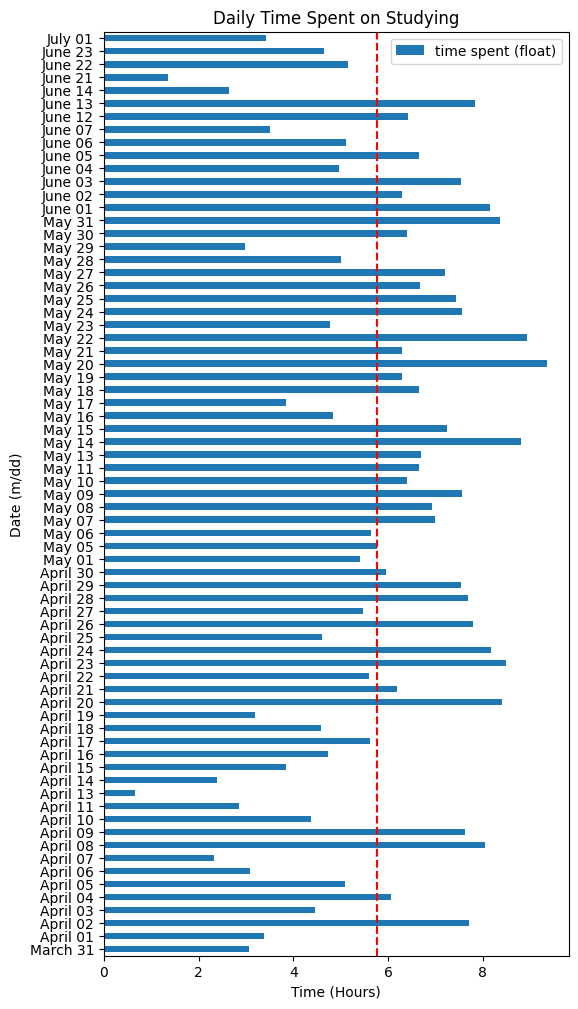

In [161]:
# Calc Mean and Standard Deviation of Daily Time Spent on Studying
mean = dfgroup_date_timespent['time spent (float)'].mean()          #<- Mean
stdev = dfgroup_date_timespent['time spent (float)'].std(ddof=1)    #<- Standard Deviation

# Plotting Bar Graph for Daily Time Spent on Studying
dfgroup_date_timespent.plot(kind='barh', x='date str', y='time spent (float)', figsize=(6, 12))
plt.axvline(mean, color='red', linestyle='--')                      #<- Mean marker on graph
plt.ylabel('Date (m/dd)')
plt.xlabel('Time (Hours)')
plt.title('Daily Time Spent on Studying')

# Terminal Output
print(f"Daily Mean (Red Line)= {mean: .3f}")
print(f"Standard Deviation = {stdev:.3f}")

### Descriptive Interpretation:
- **The average daily study duration is $5.77$ hours**.
    - $5.77\: \text{hours} = 5\: \text{hours}$ and $46\: \text{minutes}$.
    - Showed by the vertical red line.
    - **I spend time studying about $5.77$ hours daily on average**.

- **Standard deviation is $1.97$ hours**.
    - The average variation of daily time spent on studying is $1.97$ hours.
    - $1.97\: \text{hours} = 1\: \text{hour}$ and $58\: \text{minutes}$
    - **The daily time duration could vary on average of $1.97$ hours from $5.77$ hours**.

- Bars **from mid-$\text{April}$ to mid-$\text{June}$** are higher than other dates. 
    - Shows **increased duration of studying**.
    - Could be one reason why there's higher average study duration (indicated by the red line) than how it looks.

- **From the start to the $\text{April}\: 19$, time spent seems to be lower on average than later dates**
    - These are the dates when I am studying Unit 8, Counting, Permutations and Combinations.
    - Seeing these in line graph will be much more clearer.

Mean =  5.769
Standard Deviation =  1.969


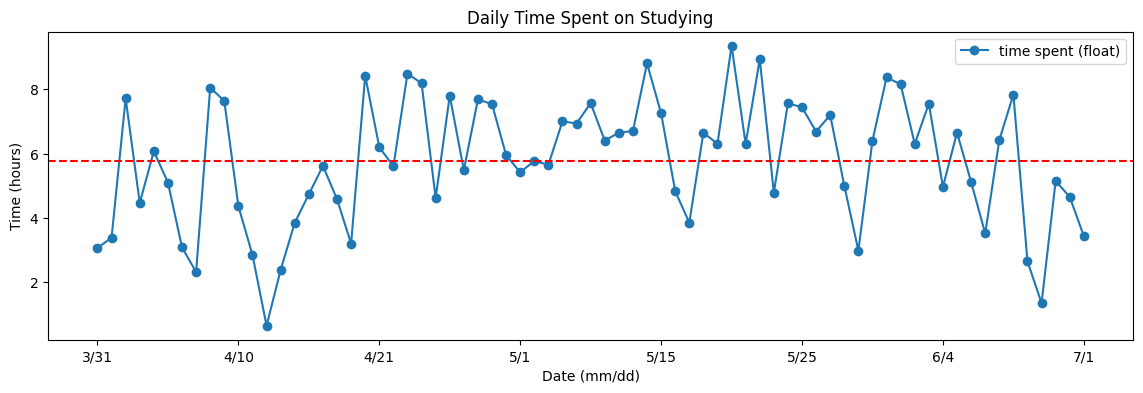

In [162]:
# Plotting in Line Graph to See Clearer on the Variation of Data Points
dfgroup_date_timespent.plot(kind='line', x='month/day', y='time spent (float)', figsize=(14, 4), marker='o')    #<- Line graph plotting
plt.axhline(mean, color='red', linestyle='--')          #<- Mean marker
plt.ylabel('Time (hours)')
plt.xlabel('Date (mm/dd)')
plt.title('Daily Time Spent on Studying')

# Terminal Output
print(f"Mean = {mean: .3f}")
print(f"Standard Deviation = {stdev: .3f}")

### Descriptive Interpretation:
- The **average variation from the red line** (the mean) is **$1.97$ hours**.
    - $1.97\: \text{hours} = 1\: \text{hour}$ and $58\: \text{minutes}$
    - Each time I study, **there's a chance that my study time would be either $1.97$ hours lower or higher on average than the average hours** I spend studying.

- Study duration from **$\text{April}\: 21$ through $\text{July}\: 1$ are higher and there are less variations** than the overall mean and standard deviation.
    - Variations are how far the data points from the mean (red line).
        - On average, data points are less further from the mean line. 
        - **This could indicate higher motivation times of me studying**.

- Meanwhile, study duration from **$\text{March}\: 31$ through $\text{April}\: 21$ are lower and there are more variations**.
    - **Could indicate that I am study less time and doing other things, than later the months**.

### **Data Distribution**

Skewness = -0.38020423836283807


count    91.000000
mean      5.751099
std       1.771046
min       0.650000
25%       4.600000
50%       5.766667
75%       6.958333
max       9.350000
Name: time spent (float), dtype: float64

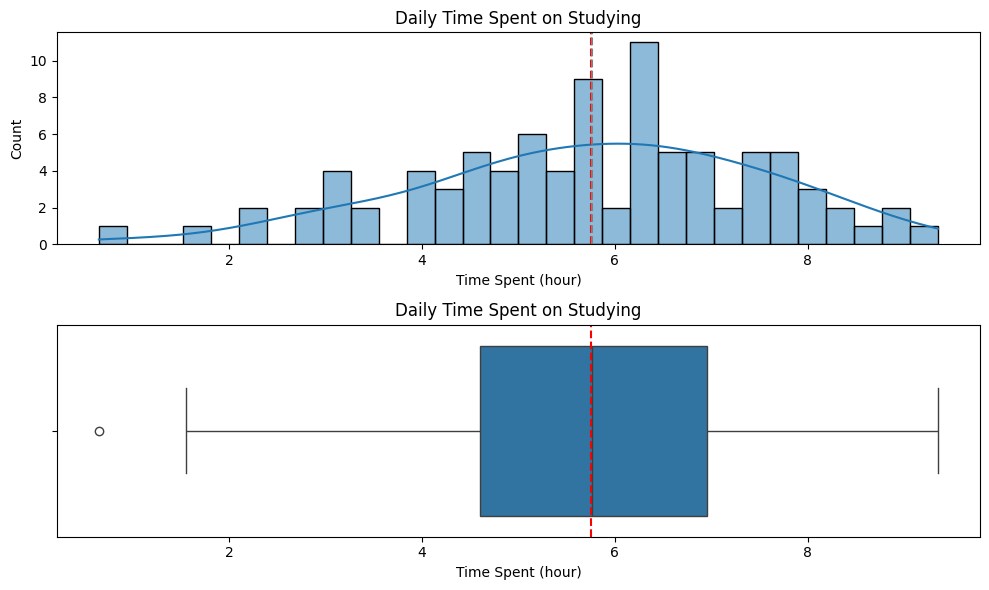

In [72]:
# Plotting in Histogram and Box Plot for Other Details 
mean_date_time_spent = dfgroup_date_timespent['time spent (float)'].mean()
median_date_time_spent = dfgroup_date_timespent['time spent (float)'].median()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))                                         #<- Subplotting to form 2 plots in 1 figure

# Histogram
ax1 = sns.histplot(x=dfgroup_date_timespent['time spent (float)'], ax=axes[0], kde=True, bins=30)   #<- Histogram
ax1.axvline(mean_date_time_spent, color='red', linestyle='--')                                      #<- Mean line (red)
ax1.axvline(median_date_time_spent, color='gray', linestyle='--')                                   #<- Median line (gray)
ax1.set_title('Daily Time Spent on Studying')                                                       #<- Title
ax1.set_xlabel('Time Spent (hour)')                                                                 #<- x label

# Box Plot
ax2 = sns.boxplot(x=dfgroup_date_timespent['time spent (float)'], ax=axes[1])           #<- Box Plot
ax2.axvline(mean_date_time_spent, color='red', linestyle='--')                          #<- Mean line (red)
ax2.set_title('Daily Time Spent on Studying')                                           #<- Title
ax2.set_xlabel('Time Spent (hour)')                                                     #<- x label

plt.tight_layout()

print(f"Skewness = {scistat.skew(dfgroup_date_timespent['time spent (float)'])}")       #<- Skew
dfgroup_date_timespent['time spent (float)'].describe()                                 #<- Detail Table

### Descriptive Interpretation:
- **Skewness is around $-0.224$**.
    - Skewness is around $-0.22$, which is nearer to $0$ than $-0.5$.
    - **Can safely assume that the distribution is normally distributed**.
    - We can use parametric hypothesis test tools if hypothesis testing is needed.

- **mean = $5.7$ and median = $5.6$ hours**.
    - $5.7$ hours = 5 hours and 42 minutes
    - $5.6$ hours = 5 hours and 36 minutes
    - Mean and Median are too close to each other.
        - **Further reinforces how it is safe to assume its normality**.
    - I study about $5.71$ hours (5 hous and 43 minutes) daily on average.

- **Interquartile range of $4.45$ - $7.55$ hours**.
    - Range of the typical daily time spends on studying.
    - $4.45$ hours = $4$ hours and $27$ minutes
    - $7.55$ hours = $7 hours and $33$ minutes
    - **Typical hours I spend on studying is between $4.45$ and $7.55$ hours**.
    - Consistent studying time between 4 hrs and 25 minutes to 7 hrs and 33 minutes.

- Since the distribution is normal.
    - We'll use **mean as our central tendency** and **standard deviation for our variability**.
        - Useful for parametric hypothesis testing later.
    - There is an **average of $5.7$ hours of I spend on studying daily**.
        - $5.7$ hours = $5$ hours and $42$ minutes
    - **Standard deviation of $2.03$ hours**.
        - Varying uncertainty of time spent.
            - Reason why median is not an absolute value as estimator.
        - Daily time spent on studying may vary by $2.03$ hours.
            - $2.03$ hours = $2$ hours and $2$ minutes
            - **Daily time spent may vary $2.03$ hours above or below the mean**.
            
- 📝 **In Summary:**
    - ✅Distribution is **safe to assume that is normally distributed**.
    - ✅There is an **average of $5.7$ hours of I spend on studying daily**.
    - ✅**Daily time spent may vary on average of $2.03$ hours above or below $5.7$ hours**.
    - ✅**Typical hours I spend studying is between $4.45$ and $7.55$ hours**.

### `date` (day of a week) vs. `time spent (float)`

In [73]:
# Setting the Df
df_day_str = pd.merge(df['date'].dt.day_name().reset_index(), df['time spent (float)'].reset_index(), on='index')
df_day_str

,index,date,time spent (float)
0,0,Monday,3.066667
1,1,Tuesday,0.366667
2,2,Tuesday,0.983333
3,3,Tuesday,0.800000
4,4,Tuesday,1.233333
...,...,...,...
559,559,Thursday,1.633333
560,560,Thursday,0.133333
561,561,Friday,1.916667
562,562,Friday,1.350000


In [74]:
# Setting DF for Comparing Total Time Spend vs. Count of Study Session
df_day_str_total = df_day_str.groupby('date')['time spent (float)'].sum().reset_index().sort_values(by='date', ascending=False)
df_day_str_count = df_day_str['date'].value_counts()                 #<- Count of study sessions

# Merging Two Table (Totals and Counts)
df_day_str_ct = pd.merge(df_day_str_total, df_day_str_count, on='date', sort=True)

df_day_str_ct

,date,time spent (float),count
0,Friday,69.450000,72
1,Monday,68.950000,61
2,Saturday,58.766667,86
3,Sunday,67.916667,72
4,Thursday,81.050000,97
5,Tuesday,86.966667,90
6,Wednesday,90.250000,86


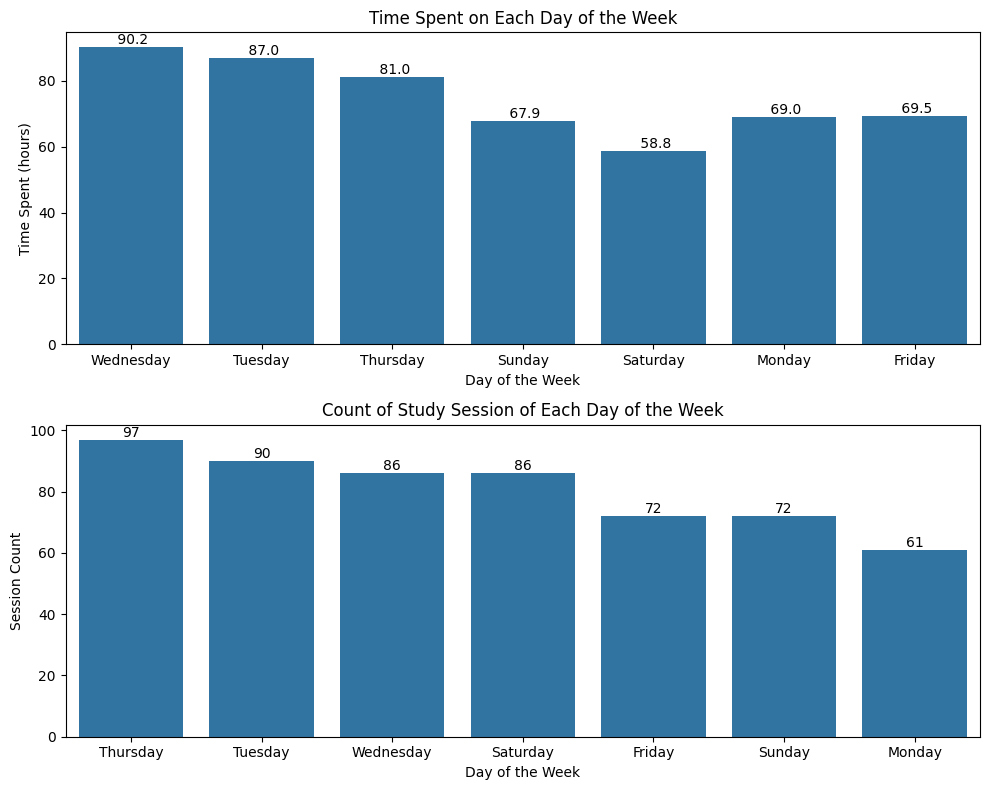

In [75]:
# Setting Subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Time Spent on Each Day of the Week
plot1 = sns.barplot(data=df_day_str_total, x='date', y='time spent (float)', ax=axes[0])
for bar in plot1.patches:               #<- Data labels
    height = bar.get_height()

    if height > 0:
        plot1.text(bar.get_x() + bar.get_width()/2, height, f'{height: .1f}', va='bottom', ha='center')
plot1.set_title('Time Spent on Each Day of the Week')
plot1.set_xlabel('Day of the Week')
plot1.set_ylabel('Time Spent (hours)')

# Count of Study Session of Each Day of the Week
plot2 = sns.barplot(df_day_str_count, ax=axes[1])
for bar in plot2.patches:               #<- Data labels
    height = bar.get_height()

    if height > 0:
        plot2.text(bar.get_x() + bar.get_width()/2, height, f'{height:.0f}', va='bottom', ha='center')
plot2.set_title('Count of Study Session of Each Day of the Week')
plot2.set_ylabel('Session Count')
plot2.set_xlabel('Day of the Week')

plt.tight_layout()

## **Descriptive Interpretation:**
- It seems I tend to study **more on Wednesday** with **61.6 total hours** spent.
- I spend **less time** to study during **Friday** with **total of 37.5 hours**.
- Despite Wednesday has the largest time I spent studying, it **ranks 3rd when it comes to the count of study sessions**.

### `Unit` vs. `time spent (float)`

In [76]:
# Setting Df for `Unit` and `time spent (float)` with `.groupby()`
dfgroupby_unit_timespent = df.groupby('Unit')['time spent (float)'].sum().reset_index()
dfgroupby_unit_timespent['unit desc.'] = dfgroupby_unit_timespent['Unit'].map(unit_desc)    #<- Adding more description on `Unit`

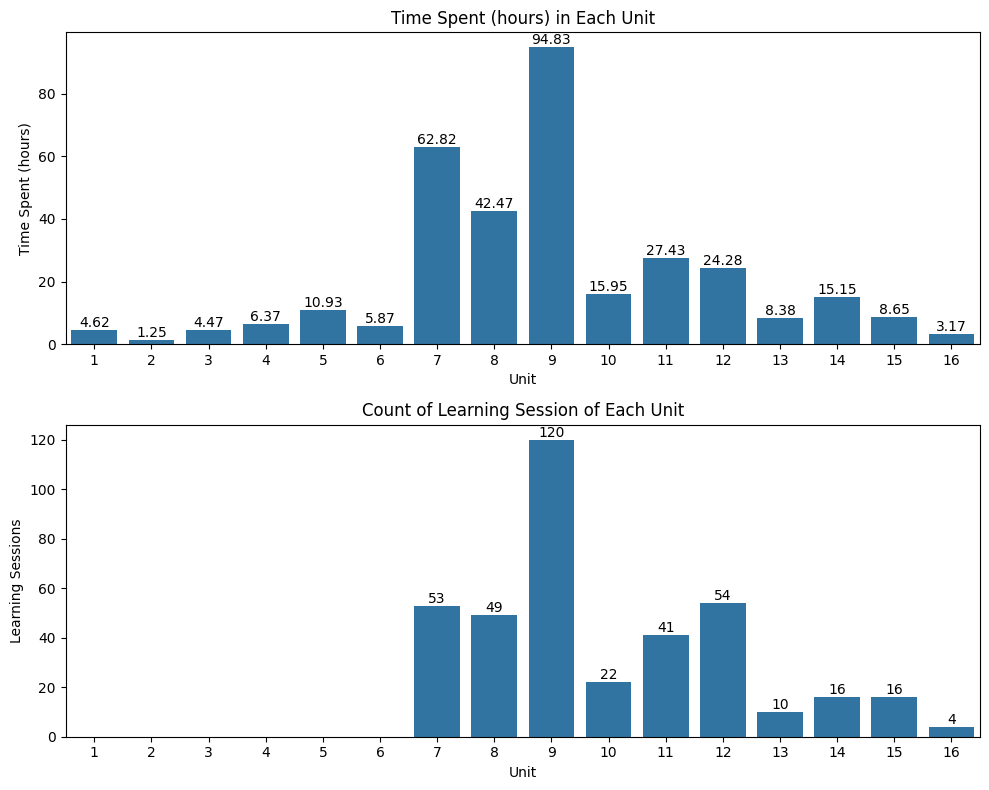

In [77]:
# Plotting Time Spent in Each Unit
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Time Spent in Each Unit
ax1 = sns.barplot(data=dfgroupby_unit_timespent, x='Unit', y='time spent (float)', ax=ax[0])
for bar in ax1.patches:
    height = bar.get_height()

    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', va='bottom', ha='center')

ax1.set_title('Time Spent (hours) in Each Unit')
ax1.set_ylabel('Time Spent (hours)')

# Count of Learning Session of Each Unit
ax2 = sns.barplot(data=df.groupby('Unit')['Lesson'].count(), ax=ax[1])
for bar in ax2.patches:
    height = bar.get_height()

    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, height, f'{height:.0f}', va='bottom', ha='center')

ax2.set_title('Count of Learning Session of Each Unit')
ax2.set_ylabel('Learning Sessions')

plt.tight_layout()

In [78]:
dfgroupby_unit_timespent[['unit desc.', 'Unit', "time spent (float)"]]

,unit desc.,Unit,time spent (float)
0,Analyzing Catergorical Data,1,4.616667
1,Displaying and Comparing Quantitative Data,2,1.250000
2,Summarizing Quantitative Data,3,4.466667
3,Modeling Data Distributions,4,6.366667
4,Exploring Bivariate Numerical Data,5,10.933333
5,Study Design,6,5.866667
6,Probability,7,62.816667
7,"Counting, Permuatations, and Combinations",8,42.466667
8,Random Variables,9,94.833333
9,Sampling Distribution,10,15.950000


### **Descriptive Insight:**
- **Unit 9: Random Variables** took most of my time studying for about **94.83 hours**.
- I **spend second** to that is the **Unit 7: Probability** for **62.817 hours**.
- I spent **the least** is **Unit 2: Displaying and Comparing Quantitative Data** for **1.25 hours**.
    - The data entry was mainly about learning project though, not the learning content itself.

Data Entry Counts per Unit:
- Mean of medians = 1.001
- Std of medians = 0.572


Text(0, 0.5, 'Time Spent (hours)')

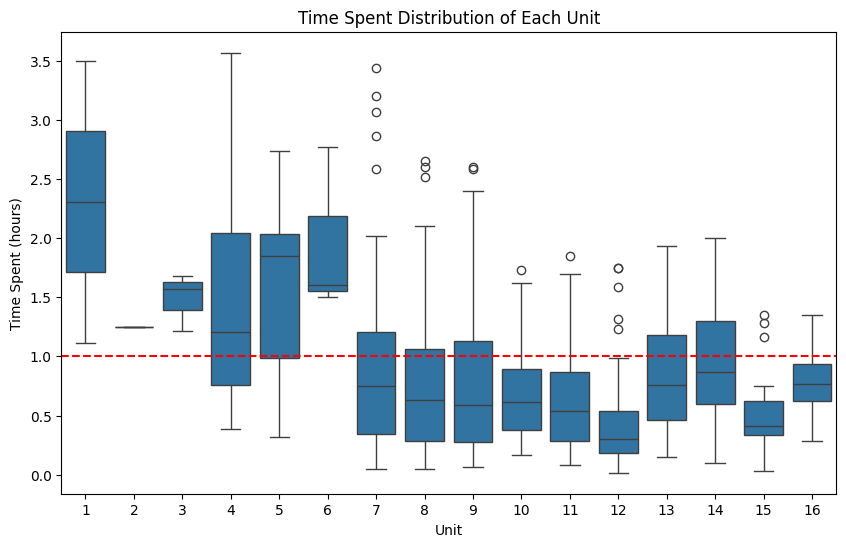

In [79]:
# Setting Df for `Unit` and `time spent (float)`
df_unit_timespent = df.loc[:, ['Unit', 'time spent (float)']]

# Data Entry Counts per Unit
unit_df = df.groupby('Unit')['time spent (float)'].agg(['count', 'sum', 'median'])  #<- Vectorized version, but let's do it manually just because I can
# unit_df = df_unit_timespent['Unit'].value_counts().reset_index().sort_values(by='Unit') #<- Study sessions made in each unit

# unit_time_spent = {}

# for i, detail in df.iterrows():                                             #<- Iter original Df
#     if detail['Unit'] not in unit_time_spent.keys():                        #<- Check unit if in empty dict
#         unit_time_spent[detail['Unit']] = []                                
    
#     unit_time_spent[detail['Unit']].append(detail['time spent (float)'])    #<- Sorting study time based on unit number

# # Calculations for Median
# total_time = {}
# median = {}
# for key, val in unit_time_spent.items():                                    #<- Iter sorted study time of each unit
#     if key != np.nan:
#         print(type(key), key)
#         total_time[key] = np.sum(val)
#         median[key] = np.median(val)

# for i, j in total_time.items():
#     print(i, ":", j)
# unit_df['total time (hr)'] = unit_df['Unit'].map(total_time)                #<- Sum of study time of each unit
# unit_df['median'] = unit_df['Unit'].map(median)                             #<- Median of study time of each unit

# Terminal Output
print('Data Entry Counts per Unit:')
print(f"- Mean of medians = {unit_df['median'].mean():.3f}")                #<- Prints mean of "median"
print(f"- Std of medians = {unit_df['median'].std(ddof=1):.3f}")            #<- Prints std of "median"

# Plotting Box Plot for each Unit
plt.figure(figsize=(10, 6))                                                 #<- Figure size customization
sns.boxplot(data=df_unit_timespent, x='Unit', y='time spent (float)')       #<- Boxplot
plt.axhline(unit_df['median'].mean(), color='red', linestyle='--')          #<- Median line (red)
plt.title('Time Spent Distribution of Each Unit')                           #<- Title
plt.ylabel('Time Spent (hours)')                                            #<- y-label

Visual Detail Assistance for the Box Plots of each Unit

In [80]:
# Visual Detail Assistance for the Box Plots
df.groupby('Unit')['time spent (float)'].describe().transpose().round(3)

Unit,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,2.000,1.00,3.000,4.000,7.000,3.000,68.000,54.000,120.000,23.000,42.000,55.000,10.000,17.000,16.000,4.000
mean,2.308,1.25,1.489,1.592,1.562,1.956,0.924,0.786,0.790,0.693,0.653,0.442,0.838,0.891,0.541,0.792
std,1.685,NaN,0.243,1.398,0.888,0.704,0.787,0.677,0.621,0.417,0.461,0.418,0.545,0.517,0.398,0.437
min,1.117,1.25,1.217,0.383,0.317,1.500,0.050,0.050,0.067,0.167,0.083,0.017,0.150,0.100,0.033,0.283
25%,1.712,1.25,1.392,0.758,0.983,1.550,0.342,0.283,0.279,0.375,0.288,0.183,0.458,0.600,0.337,0.621
50%,2.308,1.25,1.567,1.208,1.850,1.600,0.750,0.633,0.592,0.617,0.542,0.300,0.758,0.867,0.408,0.767
75%,2.904,1.25,1.625,2.042,2.033,2.183,1.208,1.062,1.129,0.892,0.871,0.542,1.179,1.300,0.625,0.938
max,3.500,1.25,1.683,3.567,2.733,2.767,3.433,2.650,2.600,1.733,1.850,1.750,1.933,2.000,1.350,1.350


### Descriptive Interpretation:
- **REMEMBER:** Unit 1 through 6 does not include the proper lesson study session.
    - Only the learning projects.
        - Also observe on the table where these units have lower time spent counts than other units.
    - We can't safely say that spent longer times to study the lesson.
        - Instead, it says that **I spent consistent longer times doing the learning projects from unit 1 through 6.**
- **Lesson proper studies was recorded starting from Unit 7 through 16**. 
    - These also include the learning projects.
    - **We use median** here since the **distribution is skewed to higher whisker**.
        - Evident on how most box plots have **longer upper whiskers than lower whiskers**.
- The **Mean of medians of daily study time per unit is ~ $1$ hour**.
    - This means I **consistently spends ~$1$ hour of studying on each study session of each unit**.

#### Data Distribution of Time Spent on Every Study Session:

Skewness = 1.217209772196635


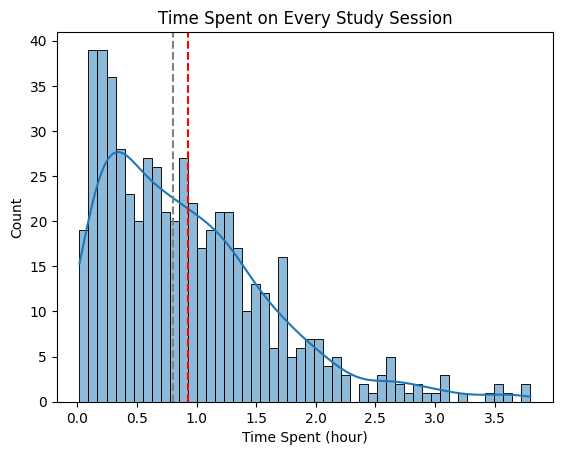

In [81]:
# Setting Data Distribution of Time Spend on Every Study Session
sns.histplot(data=df_unit_timespent, x='time spent (float)', kde=True, bins=50)             #<- Histgram
plt.axvline(df_unit_timespent['time spent (float)'].mean(), color='red', linestyle='--')    #<- Mean line (red)
plt.axvline(df_unit_timespent['time spent (float)'].median(), color='gray', linestyle='--') #<- Median line (gray)
plt.title('Time Spent on Every Study Session')                                              #<- Title
plt.xlabel('Time Spent (hour)')                                                             #<- xlabel

# Terminal Output
print(f"Skewness = {scistat.skew(df_unit_timespent['time spent (float)'])}")                #<- Skewness

### Total Study Time Spend on Each Unit

Skewness =  1.835
Interquartile Range (IQR) = 5.554 - 25.071
Median Absolute Deviation (MAD) = 5.758


count    16.000000
mean     21.039583
std      25.662850
min       1.250000
25%       5.554167
50%       9.791667
75%      25.070833
max      94.833333
Name: sum, dtype: float64

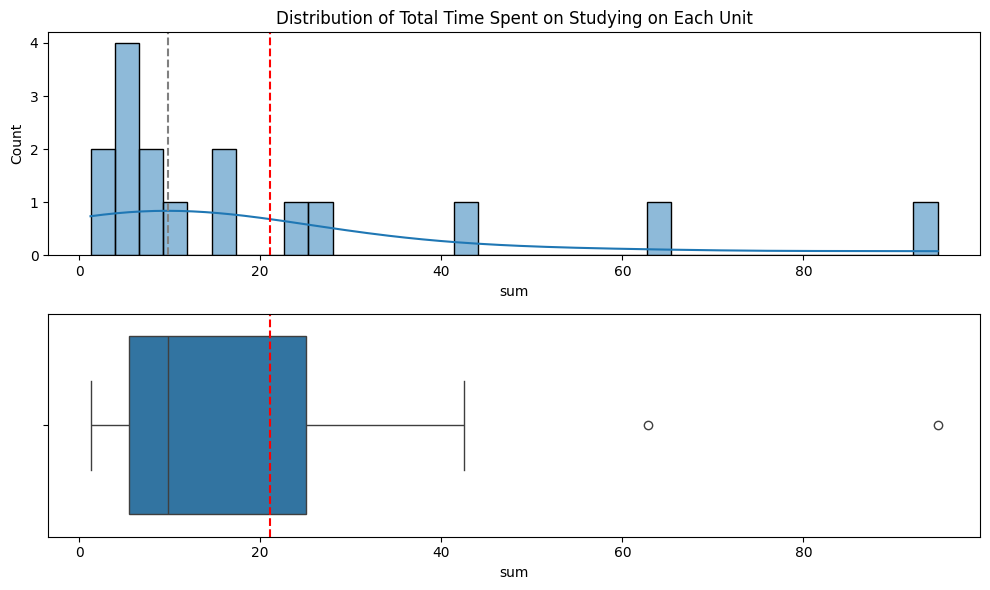

In [82]:
# Data Distribution of Total Study Time Spend on Each Unit
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Histogram
ax1 = sns.histplot(x=unit_df['sum'], bins=35, kde=True, ax=ax[0])       #<- Histogram
ax1.axvline(unit_df['sum'].mean(), color='red', linestyle='--')         #<- Mean line (red)
ax1.axvline(unit_df['sum'].median(), color='gray', linestyle='--')      #<- Median line (gray)
ax1.set_title('Distribution of Total Time Spent on Studying on Each Unit')          #<- Title

# Box Plot      
ax2 = sns.boxplot(x=unit_df['sum'], ax=ax[1])                           #<- Box plot
ax2.axvline(unit_df['sum'].mean(), color='red', linestyle='--')         #<- Mean line (red)

plt.tight_layout()

# Terminal Output
descr_unit_df = unit_df['sum'].describe()

print(f"Skewness = {scistat.skew(unit_df['sum']): .3f}")
print(f'Interquartile Range (IQR) = {descr_unit_df['25%']:.3f} - {descr_unit_df['75%']:.3f}')
print(f"Median Absolute Deviation (MAD) = {scistat.median_abs_deviation(unit_df['sum']):.3f}")
descr_unit_df

### Descriptive Interpretation:
- The distribution is **skewed to the right**.
    - The skewness is ~$1.84$, which is over to $0.5$ to consider as roughly normal.
    - Also evident how there **right whisker is longer than the left whisker**, and the presence of **large outliers**.
        - These further reinforces the skewness of the distribution.

- **Median is used instead of the mean**.
    - In skewed data, median is more reliable than mean (average).
    - **Median is ~$9.79$ hours**.
        - $9.79$ hours = **$9$ hours and $47$ minutes**    
        - It took me a median of ~$9.79$ hours to finish each Unit in Khan Academy.

- **Median Absolute Deviation is ~$5.76$ hours**.
    - The variability of total time to complete one unit.
    - $5.56$ hours = **5 hours and 34 minutes**.
    - **On average, it could take me either less than or greater than $5.56$ hours from median** to complete a unit.
    
- **Interquartile Range of $5.554$ - $25.071$ hours**.
    - The range where the total time to complete one unit likely lands.
    - $5.554$ = 5 hours and 33 minutes
    - $25.071$ = 25 hours and 4 minutes
    - The median is between $5.554$ - $25.071$ hours.
        - **If my completion time is typical, it could land in this range**.

- 📝**In Summary:**
    - ⚠️The distribution is **skewed to the right**
    - ✅It took me a median of ~$9.79$ hours to finish each Unit in Khan Academy.
    - ✅**On average, it could take me either less than or greater than $5.56$ hours from median** to complete a unit.
    - ✅**If my completion time is typical, it could land in this range**.

### Time Spent on Studying in Khan Academy
##### `Unit` vs. `time spent (float)`

In [83]:
# Filtering Category When I Only Studied in Khan Academy
df_khan_unit = df.loc[df['Category'] == 'khan academy', ['Unit', 'Lesson', 'time spent (float)', 'unit desc.']]

df_khan_timespent_unit_sum = df_khan_unit.groupby('Unit')['time spent (float)'].sum().reset_index()     #<- Total time spent in each unit
df_khan_timespent_unit_count = df_khan_unit.groupby('Unit')['Lesson'].count().rename('session count')   #<- Count of sessions

khan_timespent_unit_sum_count = pd.merge(df_khan_timespent_unit_sum, df_khan_timespent_unit_count.reset_index(), on='Unit') #<- Merge total time and count of sessions
khan_timespent_unit_sum_count['Unit Desc.'] = khan_timespent_unit_sum_count['Unit'].map(unit_desc)      #<- Appending unit description

khan_timespent_unit_sum_count

,Unit,time spent (float),session count,Unit Desc.
0,7,39.966667,47,Probability
1,8,12.950000,30,"Counting, Permuatations, and Combinations"
2,9,53.216667,81,Random Variables
3,10,15.350000,21,Sampling Distribution
4,11,23.016667,34,Confidence Intervals
5,12,20.016667,47,Significance Test (Hypothesis Testing)
6,13,8.383333,10,Two-sample Inference for the Difference Betwee...
7,14,14.516667,15,Inference for Categorical Data (Chi-square Tests)
8,15,5.550000,13,Advanced Regression (Inference and Transforming)
9,16,2.366667,3,Analysis of Variance (ANOVA)


#### Let's see how these data differ by plotting `time spend (float)` and `session count` in bar graphs.

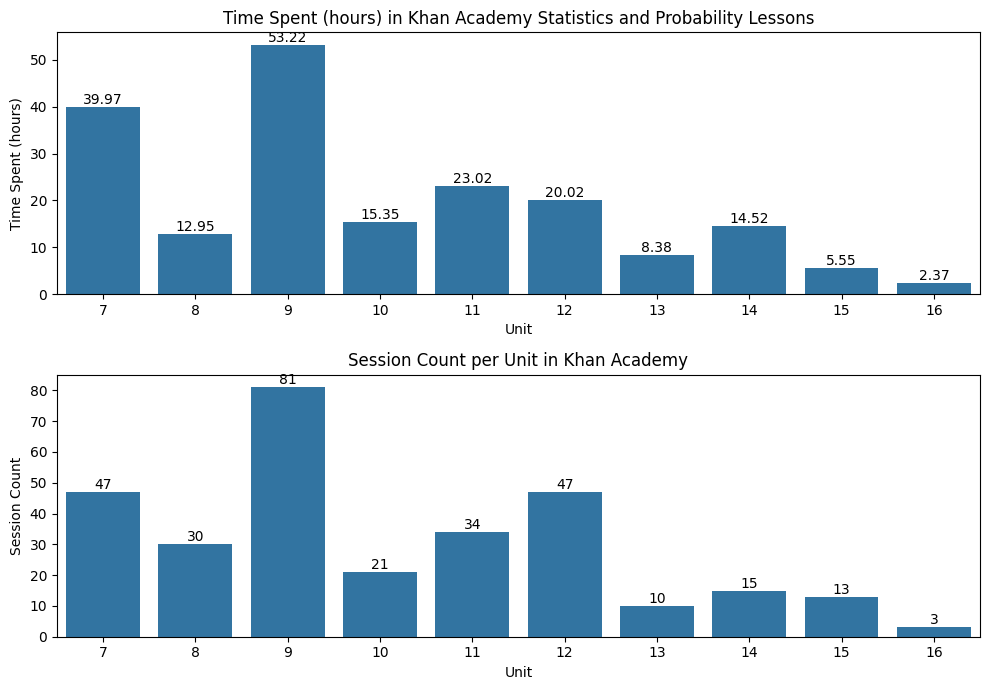

In [84]:
# Bar Graphs of Total Time Spent and Count of Sessions
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

# Plot for `Time Spent (hours) in Khan Academy Statistics and Probability Lessons`
plot1 = sns.barplot(data=khan_timespent_unit_sum_count, x='Unit', y='time spent (float)', ax=ax[0])     #<- Total time spent
for bar in plot1.patches:                                                                               #<- Data labels
    height = bar.get_height()

    if height > 0:
        plot1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', va='bottom', ha='center')
plot1.set_title('Time Spent (hours) in Khan Academy Statistics and Probability Lessons')
plot1.set_ylabel('Time Spent (hours)')

# Plot for `Session Count per Unit in Khan Academy`
plot2 = sns.barplot(data=khan_timespent_unit_sum_count, x='Unit', y='session count', ax=ax[1])          #<- Count of sessions
for bar in plot2.patches:                                                                               #<- Data labels
    height = bar.get_height()   

    if height > 0:
        plot2.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', va='bottom', ha='center')
plot2.set_title('Session Count per Unit in Khan Academy')
plot2.set_ylabel('Session Count')

plt.tight_layout()

### **Descriptive Insight:**
- **Unit 9: Random Variable has the highest time spent** among the units.
    - **It also has the highest session count** in the *Session Count per Unit in Khan Academy* bar graph.
        - Could mean that this unit is one that **has many lessons to cover** in the course.
        - Which is **associated to longer completion time** of a unit.

- **Unit 16: Analysis of Variance (ANOVA) has the least time spent** on studying among the units.
    - **It also has the least session count** in the *Session Count per Unit in Khan Academy* bar graph.
        - There could be an association between these two variables, that's why it has the least time spent among the units.
        - We'll inspect the association between session count and time spent further.

- **Observing on Unit 12**, it is 4th in terms of time spent, but ranks 3rd in terms of session counts.
    - This could mean that **despite of many study sessions, I spent less time each of those session**.
    - Leads to lesser total time spent on that unit.

#### There seems to be association between `time spend (float)` and `session count`.
Let's inspect it by using regression plot.

In [85]:
khan_timespent_unit_sum_count

,Unit,time spent (float),session count,Unit Desc.
0,7,39.966667,47,Probability
1,8,12.950000,30,"Counting, Permuatations, and Combinations"
2,9,53.216667,81,Random Variables
3,10,15.350000,21,Sampling Distribution
4,11,23.016667,34,Confidence Intervals
5,12,20.016667,47,Significance Test (Hypothesis Testing)
6,13,8.383333,10,Two-sample Inference for the Difference Betwee...
7,14,14.516667,15,Inference for Categorical Data (Chi-square Tests)
8,15,5.550000,13,Advanced Regression (Inference and Transforming)
9,16,2.366667,3,Analysis of Variance (ANOVA)


Correlation: 
- Session count vs. Time spent = 0.936


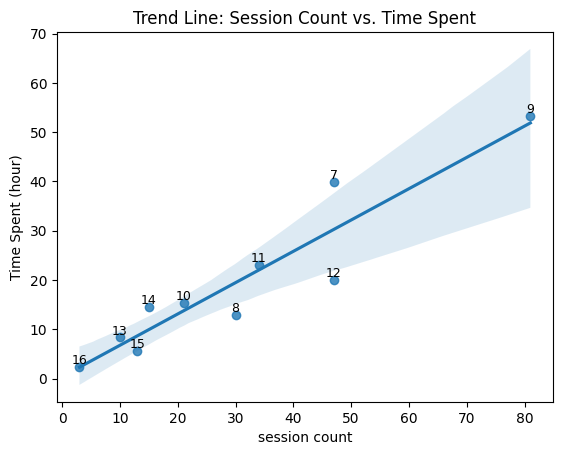

In [86]:
# Regression plot of time spent and session count
sns.regplot(data=khan_timespent_unit_sum_count, x='session count', y='time spent (float)')  #<- Regression Plot
for indx, data in khan_timespent_unit_sum_count.iterrows():                                 #<- Data label
    plt.text(x=data['session count'], y=data['time spent (float)'], s=data['Unit'], ha='center', va='bottom', fontsize=9)
plt.title('Trend Line: Session Count vs. Time Spent')                                       #<- Title
plt.ylabel('Time Spent (hour)')                                                             #<- y-label

# Correlation Table          
corr_session_count_time_spent = khan_timespent_unit_sum_count.corr(numeric_only=True)       #<- Correlation table between variables

# Terminal Output
print(f"Correlation: \n- Session count vs. Time spent = {corr_session_count_time_spent.loc['session count', 'time spent (float)']:.3f}")

### Descriptive Interpretation:
- **There's positive association** between session count and time spent (hours)
    - As session count increases, time spent also tends to increase.
    - Unit 9 has the largest session count than Unit 16.
        - **Thus, Unit 9 has longer time completion than Unit 16**.

- **Correlation tables shows there's positive assiciation** between session count and time spent.
    - Values ranges from -1 through 1.
        - 1 means perfectly positive correlation
        - 0 means no correlation
        - -1 means perfectly negative correlation
    - **Correlation is ~$0.95$** between session count and time spent.
        - **Closer to 1 than 0, which means they have high correlation**.
        - Further reinforces their positive association.

### Line graph to pin point unit progression.
#### `time spent (float)` vs. `Unit` or;
#### `session count` vs. `Unit`

Mean Time Spent = 19.533
Stdev Time Spent = 15.864

Mean Session Count = 30.100
Stdev Session Count =  23.378


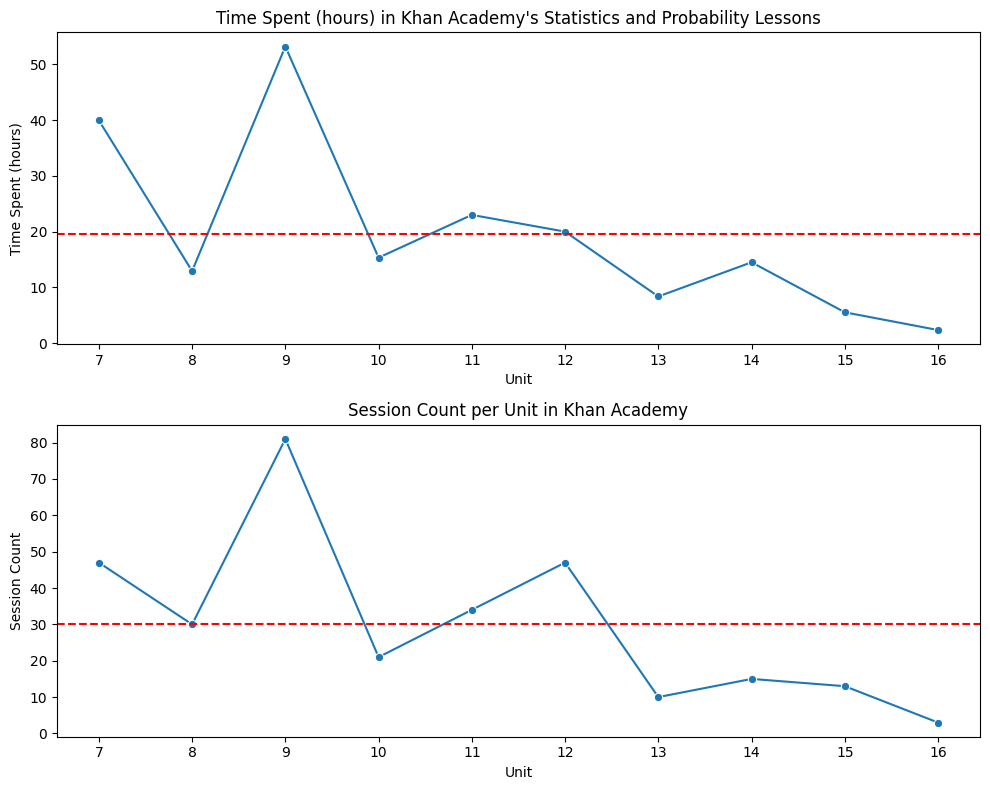

In [87]:
mean_time_spent = khan_timespent_unit_sum_count['time spent (float)'].mean()
stdev_time_spent = khan_timespent_unit_sum_count['time spent (float)'].std(ddof=1)

mean_session_count = khan_timespent_unit_sum_count['session count'].mean()
stdev_session_count = khan_timespent_unit_sum_count['session count'].std(ddof=1)

print(f"Mean Time Spent = {mean_time_spent:.3f}")
print(f"Stdev Time Spent = {stdev_time_spent:.3f}\n")

print(f"Mean Session Count = {mean_session_count:.3f}")
print(f"Stdev Session Count = {stdev_session_count: .3f}")

# Setting Subplots 
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot for `Time Spent (hours) in Khan Academy Statistics and Probability Lessons`
plot1 = sns.lineplot(data=khan_timespent_unit_sum_count, x='Unit', y='time spent (float)', ax=ax[0], marker='o')
for bar in plot1.patches:
    height = bar.get_height()

    if height > 0:
        plot1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', va='bottom', ha='center')
plot1.set_title('Time Spent (hours) in Khan Academy\'s Statistics and Probability Lessons')
plot1.set_ylabel('Time Spent (hours)')
plot1.set_xticks(np.arange(khan_timespent_unit_sum_count['Unit'].min(), khan_timespent_unit_sum_count['Unit'].max() + 1))
plot1.axhline(y=mean_time_spent, color='red', linestyle='--')

# Plot for `Session Count per Unit in Khan Academy`
plot2 = sns.lineplot(data=khan_timespent_unit_sum_count, x='Unit', y='session count', ax=ax[1], marker='o')
for bar in plot2.patches:
    height = bar.get_height()

    if height > 0:
        plot2.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', va='bottom', ha='center')
plot2.set_title('Session Count per Unit in Khan Academy')
plot2.set_ylabel('Session Count')
plot2.set_xticks(np.arange(khan_timespent_unit_sum_count['Unit'].min(), khan_timespent_unit_sum_count['Unit'].max() + 1))
plot2.axhline(y=mean_session_count, color='red', linestyle='--')

plt.tight_layout()

### **Descriptive Interpretation:**
- Both `time spent` and `session count` getting lesser as I progressed units in khan academy.
    - As unit increases, both `time spent` and `session count` are getting lesser.
    
- Unit 12 kind of unusual from the rest of the unit as it **increased the session count as the time spent keep decreasing as unit progresses**.
- Unit 12 may have an **increased number of study sessions but lesser total time spent than previous units**.

### Checking trend lines
- `Unit` vs. `time spent`
- `Unit` vs. `session count`

Correlation:
- Unit vs. Time Spent = -0.703
- Unit vs. Session Count = -0.679


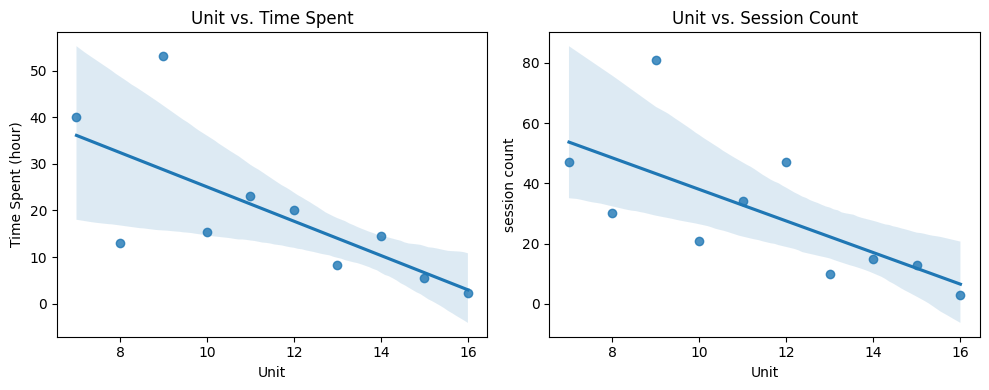

In [88]:
# Setting Subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Unit vs. Time Spent
ax1 = sns.regplot(data=khan_timespent_unit_sum_count, x='Unit', y='time spent (float)', ax=ax[0])   #<- Time spent
ax1.set_title('Unit vs. Time Spent')                                                                #<- Title
ax1.set_ylabel('Time Spent (hour)')                                                                 #<- y label

# Unit vs. Session Count
ax2 = sns.regplot(data=khan_timespent_unit_sum_count, x='Unit', y='session count', ax=ax[1])        #<- Session count
ax2.set_title('Unit vs. Session Count')                                                             #<- Title

plt.tight_layout()

# Terminal Output
print("Correlation:")
print(f"- Unit vs. Time Spent = {corr_session_count_time_spent.loc['Unit', 'time spent (float)']:.3f}")
print(f"- Unit vs. Session Count = {corr_session_count_time_spent.loc['Unit', 'session count']:.3f}")

### Descriptive Insight:
- **Unit vs. Time spent**
    - The trend line is going down as unit increases.
    - Correlation value of $-0.703$.
        - Closer to -1 than 0, this signals negative association.
    - **As unit increases, time spent tends to decrease**.
        - Shows proportionally inverse association.

- **Unit vs. Session count**
    - The trend line is going down as unit increases.
    - Correlation value of $-0.72$.
        - Closer to -1 than 0, this signals negative association.
    - **As unit increases, session count tends to decrease**.
        - Shows proportionally inverse association.

        

## `category` vs. `time spent (float)`

In [89]:
# Setting DataFrame
df_groupby_cat_time_spent = df.groupby('Category')['time spent (float)'].sum().reset_index()
df_groupby_cat_time_spent

,Category,time spent (float)
0,Learning Project,94.400000
1,khan academy,195.333333
2,personal project,109.683333
3,portfolio making,4.100000
4,"self-study (chatgpt, etc.)",119.833333


Total Time Spent = 523.350 hours


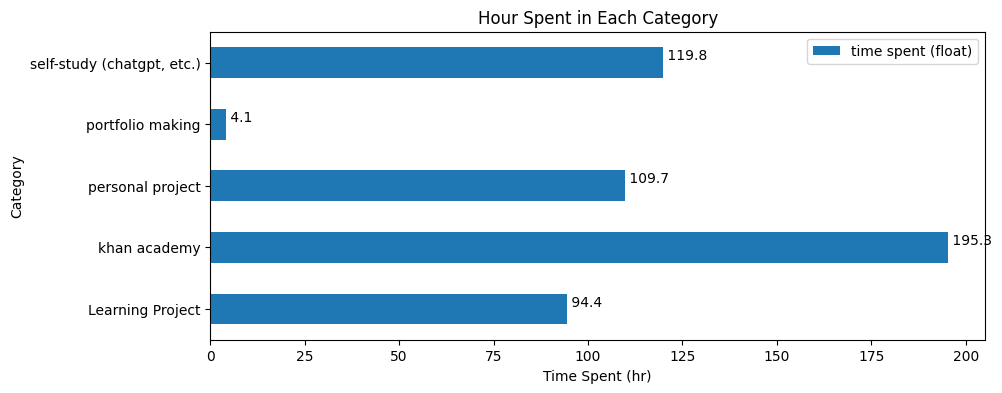

In [90]:
# Bar graph of Hour Spent in Each Category
ax = df_groupby_cat_time_spent.plot(kind='barh', x='Category', y='time spent (float)', figsize=(10, 4))     #<- Horizontar bar graph
for bar in ax.patches:                                                                                      #<- Data label
    width = bar.get_width()

    if height > 0:
        ax.text(x=width, y=bar.get_y() + bar.get_height()/2, s=f'{width: .1f}', va='bottom', ha='left')

plt.title('Hour Spent in Each Category')                                                                    #<- Title                                                                                  #<- y-label
plt.xlabel('Time Spent (hr)')                                                                               #<- x-label

# Terminal Output
print(f"Total Time Spent = {df_groupby_cat_time_spent['time spent (float)'].sum():.3f} hours")              #<- Total time spent

### **Descriptive Interpretation:**
- **Khan Academy lessons has the highest time spent**.
    - The main content I am following to learn statistics and probability.
    - I spent most time studying on **khan academy's content** by **$195.3$ hours**.
        - $195.3$ hours = $195$ hours and $18$ minutes.

- Self-study (chatgpt, youtube tutorials, etc.)
    - Supplementary contents for reinforcement the main content from Khan Academy.
    - Includes watching youtube tutorials, exploratory learning using chatgpt by prompting, reading online articles, etc.
    - Spent the most next to Khan Academy's lessons by $84.1$ hours
        - **$84.1$ hours = $84$ hours and $6$ minutes**.

- Learning Project is the least.
    - Applying what I learned by doing projects.
    - **Spend the least among the categories**, spent time about $57.2$ hours.
        - **$57.2$ hours = $57$ hours and $12$ minutes**.

- **Total time spent is ~$336.633$ hours**.
    - $336.633$ hours = 336 hours and 38 minutes

## `time_start_flt` vs. `time_end_flt`

In [91]:
# Setting DataFrame for Time Started and Time Ended
df_time_start_end = df.loc[:, ['time_start_flt', 'time_end_flt']]
df_time_start_end

,time_start_flt,time_end_flt
0,21.666667,0.750000
1,12.383333,12.750000
2,13.833333,14.816667
3,18.200000,19.000000
4,23.500000,0.750000
...,...,...
559,15.383333,17.016667
560,21.066667,21.200000
561,12.750000,14.666667
562,15.050000,16.400000


Time Started Statistic Summary:
- Skewness: -0.606
- Mode: 13.0
------------------
Time Ended Statistic Summary:
- Skewness: -1.027
- Mode: 14.0
------------------


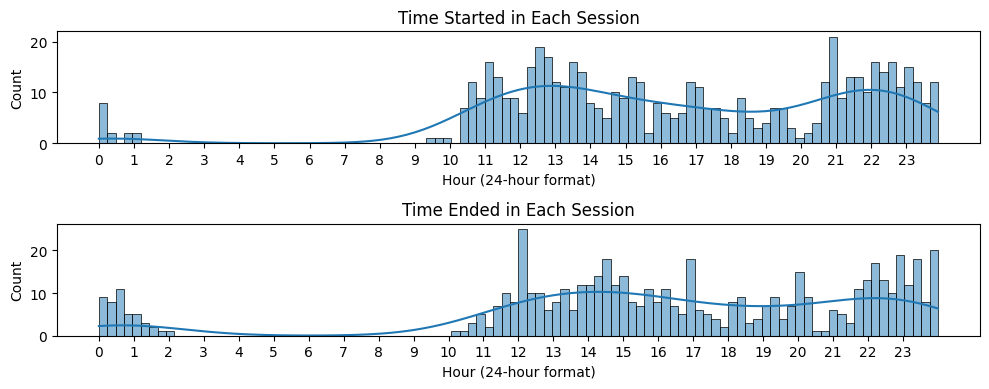

In [92]:
# Setting Neccessary Variables and Setups
cols = df_time_start_end.columns.values                                         #<- Columns (for mapping graph title)
title_label = {cols[0]: 'Time Started', cols[1]: 'Time Ended'}                  #<- Titles labels for the graph

# Plotting Distribution Plot    
fig, axplot = plt.subplots(2, 1, figsize=(10, 4))                               #<- Subplots settings

for indx, detail in enumerate(df_time_start_end.items()):                       #<- Iter cols of "time start" and "time end"
    col_name = title_label[detail[0]]                                           #<- Var for accessing title label                                                        
    dataset = detail[1].round(1)                                                #<- Dataset (rounded off to 1)
    
    # Histogram
    hist = sns.histplot(data=dataset, bins=100, kde=True, ax=axplot[indx])   #<- Histogram
    hist.set_xticks(np.arange(0, 24))
    hist.set_title(f'{col_name} in Each Session')                               #<- Title
    hist.set_xlabel('Hour (24-hour format)')                                    #<- x-label

    # Terminal Output
    print(f"{col_name} Statistic Summary:")
    print(f"- Skewness: {np.round(scistat.skew(dataset), 3)}")       #<- Skewness terminal output
    print(f"- Mode: {dataset.mode().iloc[0]}")
    print('------------------')

plt.tight_layout()

### Descriptive Insight:
**Things to Note First:**
- ⚠️The distribution **shows bimodal behavior** of the data.
    - It shows two clear peaks in the data.
        - It **forms two mountains-like distribution** in the data.
    - **There might be unaccounted groups** in these data.

- ⚠️**Central tendency and variability have no use in time-series data**.
    - Mean, median, variance, standard deviation, etc. no longer make sense in time-series data.
        - **Usable if data are transformed** to cyclical time-of-day data. 
    - **Mode can still be utilized** in this kind of data.
        - Mode determines the most frequent value among the data.
        - Mode = most frequent data

**Time Started**
- Mode is ~$22.4$ hour mark.
    - $22.4$ hour = $10:24$ PM
    - **I often or usually start to study around $10:24$ PM (evening)**.
    - The distribution is bimodal which signals there might be unaccounted groups in the data.
        - There's also peak at $13$ hour mark.
            - 13 hour = $1:00$ PM
            - This could mean that **I also often start to study around $1:00$ PM (afternoon)**.
    - **Unaccounted groups** might be the ***afternoon sessions*** and ***evening sessions***.
        - Distribution peaks at $13$ hour mark, drops after, then peaks again around $22$ hour mark.
        - The **drop of distribution around $18$ and $19$ might be because it's time for dinner or the time when I workout** during those hours. 
            - $18$ hour = $6:00$ PM
            - $19$ hour = $7:00$ PM

- Skewness is around $-0.715$.
    - **The data is skewed to the left**.
    - The **skew occurs because $0$ hour mark is midnight hours**.
        - $0$ = $12:00$ AM
        - Time when people are asleep and time to rest.
    - There are data between $0$ and $1.5$.
        - $1.5$ hour = $1:30$ AM
        - This means **I still continue to study or start new study session until midnight around $0$ and $1.5$ hour of the day**.

**Ending Time**
- Mode is $22$ hour mark.
    - $22$ hour = $10:00$ PM
    - **Among the ending session, I usually end studying around $10:00$ PM (evening)**.
        - The **ending doesn't mean I would not start a new session again**.
        - I may end a session, and start a new one.
    - The distribution is bimodal which signals there might be unaccounted groups in the data.
        - There's another peak between $13$ and $14$ hour mark.
            - 13 hour = $1:00$ PM
            - 14 hour = $2:00$ PM
            - This means that **I also often ends studying between around $1:00$ PM and $2:00$ PM (afternoon)**.
    - **Unaccounted groups** might be the ***afternoon sessions*** and ***evening sessions*** again.
        - Distribution peaks around $13$ or $14$ hour mark, drops after, then peaks again around $22$ hour mark.
        - The **drop of distribution around $18$ and $19$ might be because it's time for dinner or the time when I workout** during those hours. 

- Skewness is around $-0.989$.
    - **The data is skewed to the left**.
    - The **skew occurs because $0$ hour mark is midnight hours**.
        - $0$ = $12:00$ AM
        - Time when people are asleep and time to rest.
    - There are still data between $0$ and $2.5$.
        - $2.5$ hour = $2:30$ AM
        - This means that **I am still studying and yet to end between $0$ and $2.5$ hour of the day**.

# Regression Analysis
#### `date` vs. `time spent (float)`

In [93]:
dfgroup_date_timespent.head()

,date,time spent,time spent (float),month,day,month/day
0,2025-03-31,0 days 03:04:00,3.066667,3,31,3/31
1,2025-04-01,0 days 03:23:00,3.383333,4,1,4/1
2,2025-04-02,0 days 07:43:00,7.716667,4,2,4/2
3,2025-04-03,0 days 04:28:00,4.466667,4,3,4/3
4,2025-04-04,0 days 06:04:00,6.066667,4,4,4/4


Text(0.5, 1.0, 'Days vs. Time Spent')

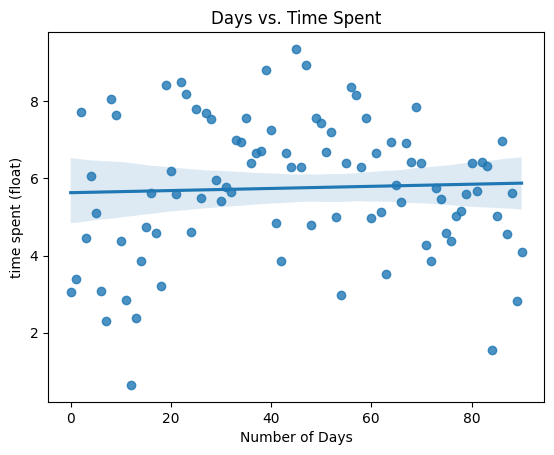

In [94]:
# Regression Plot: Number of Days vs. Time Spent
sns.regplot(data=dfgroup_date_timespent, x=dfgroup_date_timespent.index, y='time spent (float)')
plt.xlabel('Number of Days')                                                    #<- x-label
plt.title('Days vs. Time Spent')                                                #<- Title

In [95]:
# Regression Modeling (Linear)
raw_linregress = scistat.linregress(x=dfgroup_date_timespent.index, y=dfgroup_date_timespent['time spent (float)'])
a = raw_linregress.intercept                                            #<- y-intercept
b = raw_linregress.slope                                                #<- slope

# Terminal Output
print(f"y = {b: .3f}x + {a: .3f}")                                      #<- Regression model
print(f"R = {raw_linregress.rvalue: .3f}")                              #<- R
print(f"R^2 {raw_linregress.rvalue ** 2: .3f}")                         #<- R^2

y =  0.003x +  5.628
R =  0.041
R^2  0.002


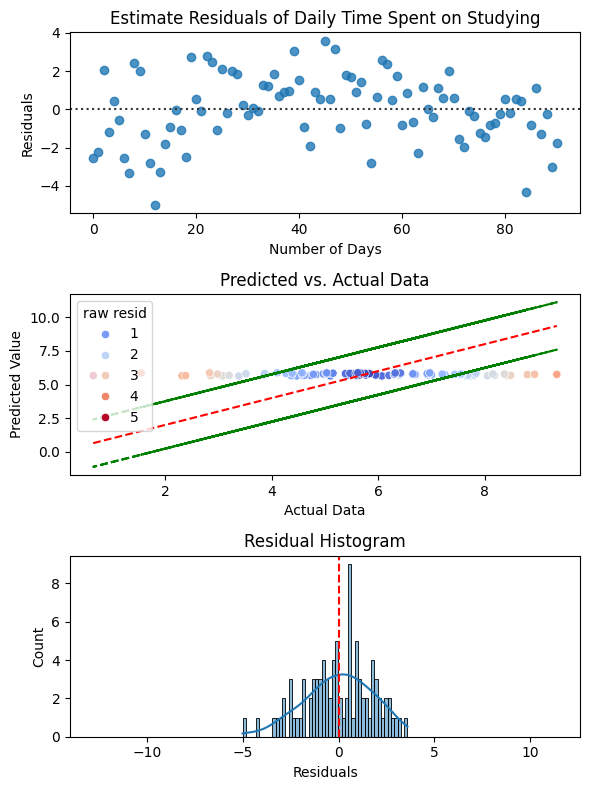

In [96]:
# Evaluating Regression Model
dfgroup_date_timespent['reg. pred.'] = b * dfgroup_date_timespent.index + a
dfgroup_date_timespent['raw resid'] = dfgroup_date_timespent['time spent (float)'] - dfgroup_date_timespent['reg. pred.']

# Regression Metrics
rmse = metrics.root_mean_squared_error(y_true=dfgroup_date_timespent['time spent (float)'], y_pred=dfgroup_date_timespent['reg. pred.'])
r2 = metrics.r2_score(y_true=dfgroup_date_timespent['time spent (float)'], y_pred=dfgroup_date_timespent['reg. pred.'])
nrmse = rmse / dfgroup_date_timespent['time spent (float)'].mean()
mae = metrics.mean_absolute_error(y_true=dfgroup_date_timespent['time spent (float)'], y_pred=dfgroup_date_timespent['reg. pred.'])

# Visualizing Regression Analysis
fig, ax = plt.subplots(3, 1, figsize=(6, 8))

# Residual Plot
plot1 = sns.residplot(data=dfgroup_date_timespent, x=dfgroup_date_timespent.index, y='raw resid', ax=ax[0])
plot1.set_xlabel('Number of Days')                                        #<- x-label
plot1.set_ylabel('Residuals')                                             #<- y-label
plot1.set_title('Estimate Residuals of Daily Time Spent on Studying')     #<- Title

# Predicted vs. Actual Data Plot
plot2 = sns.scatterplot(x=dfgroup_date_timespent['time spent (float)'], 
                        y=dfgroup_date_timespent['reg. pred.'], 
                        ax=ax[1],
                        hue=np.abs(dfgroup_date_timespent['raw resid']), 
                        palette='coolwarm')

minval = min(dfgroup_date_timespent['time spent (float)'].min(), dfgroup_date_timespent['reg. pred.'].min())
maxval = max(dfgroup_date_timespent['time spent (float)'].max(), dfgroup_date_timespent['reg. pred.'].max())
plot2.plot([minval, maxval], [minval, maxval], 'r--')

plot2.set_title('Predicted vs. Actual Data')
plot2.set_xlabel('Actual Data')
plot2.set_ylabel('Predicted Value')
plot2.plot(dfgroup_date_timespent['time spent (float)'], dfgroup_date_timespent['time spent (float)'] + rmse, 'g--')
plot2.plot(dfgroup_date_timespent['time spent (float)'], dfgroup_date_timespent['time spent (float)'] - rmse, 'g--')

# Histogram of Residual
plot3 = sns.histplot(x=dfgroup_date_timespent['raw resid'], bins=50, kde=True)
plot3.axvline(dfgroup_date_timespent['raw resid'].mean(), color='red', linestyle='--')
plot3.set_title('Residual Histogram')
plot3.set_xlabel('Residuals')

plt.axis('equal')
plt.tight_layout()

In [97]:
# Terminal Output
print('Statistical Summary:')
print(f"Mean = {mean:.3f}")                                     #<- Mean of study duration
print(f"Std = {stdev:.3f}")                                     #<- Std of study duration

print('\nRegression Metrics:')                                  #<- Regression Metrics
print(f"- R^2 = {r2: .3f}")                                     #<- R^2
print(f"- RMSE = {rmse: .3f}")                                   #<- RMSE
print(f"- NRMSE = {nrmse:.3f}")                                 #<- NRMSE
print(f"- MAE = {mae:.3f}")
print(f"- NMAE = {mae / mean:.3f}")

print('\nChecking RMSE vs. std:')
print(f'RMSE < std = {rmse:.3f} < {stdev:.3f} =  {rmse < stdev}')   #<- RMSE vs. Std

print('\nResidual Distribution:')
print(f"- Residual Skewness = {scistat.skew(dfgroup_date_timespent['raw resid']):.3f}")

Statistical Summary:
Mean = 5.751
Std = 1.771

Regression Metrics:
- R^2 =  0.002
- RMSE =  1.760
- NRMSE = 0.306
- MAE = 1.419
- NMAE = 0.247

Checking RMSE vs. std:
RMSE < std = 1.760 < 1.771 =  True

Residual Distribution:
- Residual Skewness = -0.343


## Interpretation:
- ✅RMSE is less than the Standard Deviation:
    - The **model performs better estimates than using the mean** to predict.

- ⚠️$R^2$ value is closer to 0 than 1.
    - The model only explains very little, and a large portion is unaccounted.
    - The **model is not good at capturing the real signal**.

- ⚠️NRMSE is approximately $34$%.
    - The average prediction error is about 34% of the target mean value.
    - This could mean that **if the average daily study duration is $5.706$ hours , then the prediction is $1.94$ off on average, when accounting for large mistakes**.
        - $5.706$ hour = $5$ hours and $42$ minutes
        - $1.94$ hours = $1$ hour and $56$ minutes
    - **$34$% NRMSE lies on the acceptable side.**.
    - Need more data transformation to come up with good regression model.

- ✅Residual Plot: Scattered Around the Model.
    - If the model is making consistent mistakes or missing important relationships
    - Does not show any patterns that could hint bias.
    - **Errors of the model seems show no consistent bias**.

- ⚠️Predicted vs. Actual Data
    - Shows how close the model's guess (prediction) is to the real answer.
    - There are more dots that are below the line than above the line.
        - **The model is probably overestimating**.

- ✅Residual Distribution:
    - Checks how the errors are distributed.
    - **Skewness is $-0.216$**.
        - It is between $0$ and $-0.5$, which **can be considered as roughly normal**.
            - **The model predicts with no consistent bias.**
            - **Negative skewness shows that the model a bit overestimating**.

- **Overall Evaluation:**
    - The **model performs better estimates than using the median** alone.
    - The model is **not good at capturing the real signal**.
    - The model is **$34$% off on average** when large mistakes are accounted.
    - The model **shows no consistent biased prediction**.
    - The model is **a bit overestimating** from the true value.

## **Confidence Interval for Population Estimate**

Average Time Spent Daily =  5.751
Standard Deviation =  1.771
Sample Size = 91
Skewness = -0.380


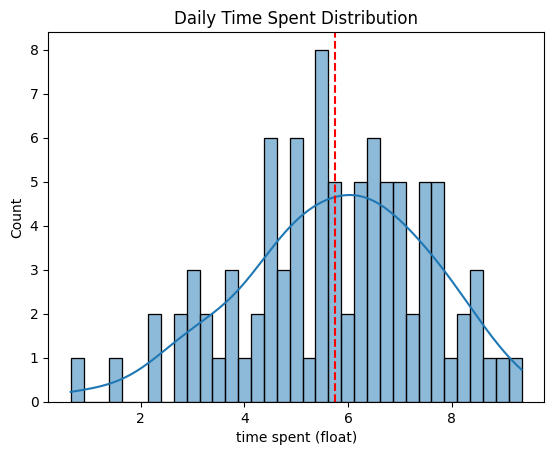

In [98]:
# Setting Dataframe and Neccessary Variables
time_spent_daily = dfgroup_date_timespent['time spent (float)']     #<- Daily study duration dataframe

mean = time_spent_daily.mean()                                      #<- Mean of daily study duration
stdev = time_spent_daily.std(ddof=1)                                #<- Std of daily study duration
n = len(time_spent_daily)                                           #<- Total number of daily study session


# Plotting the Data
sns.histplot(data=time_spent_daily, bins=35, kde=True)              #<- Histogram
plt.axvline(x=mean, color='red', linestyle='--')                    #<- Mean line (red)
plt.title('Daily Time Spent Distribution')                          #<- Title

skewness = scistat.skew(time_spent_daily)                           #<- Skewness

# Terminal Output
print(f"Average Time Spent Daily = {mean: .3f}")
print(f"Standard Deviation = {stdev: .3f}")
print(f"Sample Size = {n}")
print(f"Skewness = {skewness:.3f}")

### Checking if can be safely assume it is Normaly Distributed with these conditions:
1. **Random Condition**
    - Data are sampled randomly
2. **Independence Condition**
    - Data are independent to one another
3. **Normality Condition**
    - Data are forming a bell-curve, or
    - Data have Shapiro-Wilk test less than $0.05$

### Checking Random and Independence Condition

Text(0.5, 1.0, 'Autocorrelation of Daily Time Spent')

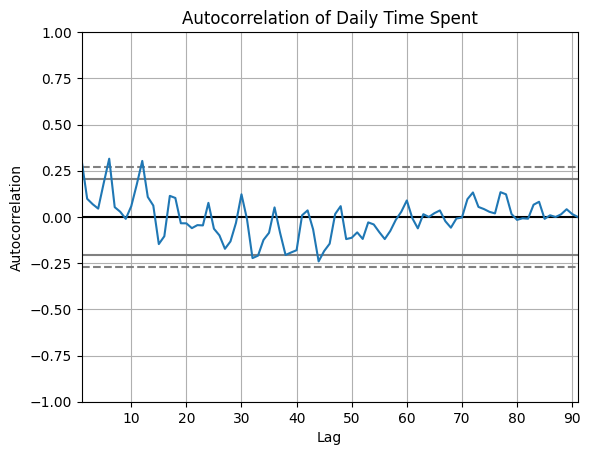

In [99]:
# Checking Independence and Random Condition
pd.plotting.autocorrelation_plot(time_spent_daily)
plt.title('Autocorrelation of Daily Time Spent')

### Random and Independence Conditions

With `autocorrelation_plot()`, we can test whether the data values are correlated with their own past. Basing on the result of the plot, it shows and mean:
1. **Data points are mostly contain inside $\pm 0.25$** and only two data points are outside
    - This means it is safe to assume the independece of each data.
2. **Because of independence, data usually appear randomly**.

We can confirm to safely assume:
- ✅**Independence Condition**
- ✅**Random Condition**

### Normality Condition

In [100]:
# Checking Normality (First Method)
print('Method 1:')
if len(time_spent_daily) >= 30:
    print(f"Safe to assume normality ({len(time_spent_daily)} >= 30 is {len(time_spent_daily) >= 30})")
else:
    print(f"Not safe to assume normality ({len(time_spent_daily)} >= 30 is {len(time_spent_daily) >= 30})")

# Checking Normality (Second Method)
stat, pval = scistat.shapiro(dfgroup_date_timespent['time spent (float)'])

print('\nMethod 2:')
if pval > 0.05:
    print(f"Normality is not rejected ({pval: .3f} > 0.05)")
else: 
    print(f"Distribution is not normal ({pval: .3f} < 0.05)")

Method 1:
Safe to assume normality (91 >= 30 is True)

Method 2:
Normality is not rejected ( 0.460 > 0.05)


Since both method confirms (just to make sure) normality, it is safe to assume:
- ✅Normal Condition

### Now we're ready to predict the interval where my next study time probably land.

In [101]:
# Confidence Level and Confidence Interval
conf_lvl = 0.95
conf_inter = scistat.t.interval(conf_lvl, df=n-1, loc=mean, scale=stdev/np.sqrt(n))

# Terminal Output
print(f"Confidence Interval = ({conf_inter[0]:.3f}, {conf_inter[1]:.3f})")

Confidence Interval = (5.382, 6.120)


### **Inferential Interpretation:**
- The **interval is $5.177$ hours and $6.234$ hours**.
    - $5.177$ hours = $5$ hours and $11$ minutes
    - $6.234$ hours = $6$ hours and $14$ minutes
- **There's $95$% confidence that's where my true average daily study duration lies.**
    - **My true average daily study duration is between 5.177 and 6.234 hours**.
    - $95$% confidence doesn't mean the chance of getting between this interval.
        - If we sample again and again then get their confidence interval, $95$% of these intervals will likely catch the true population mean.
        - Random Sampling Simulation is provided below for further context.
            - We are treating the sample I collected is the population.

## **Simulating Sample on Capturing the Interval**
- If we **resample 1000 trials** with **sample size of 35**:
    - *How many times will it capture* the sample mean in their intervals?

Supposed Population Mean = 5.751 hours (red line)
Means of Sample Means = [5.10714286 5.39714286 5.45095238 5.97857143 5.03333333]
Stdev of Samples = [1.94499645 1.80751195 1.91543414 1.72317712 2.044325  ]

Capture Percentage = 95.00%


,mean,stdev,MOE,lower ci,upper ci
0,5.107143,1.944996,0.668130,4.439,5.775
1,5.397143,1.807512,0.620902,4.776,6.018
2,5.450952,1.915434,0.657975,4.793,6.109
3,5.978571,1.723177,0.591932,5.387,6.571
4,5.033333,2.044325,0.702250,4.331,5.736


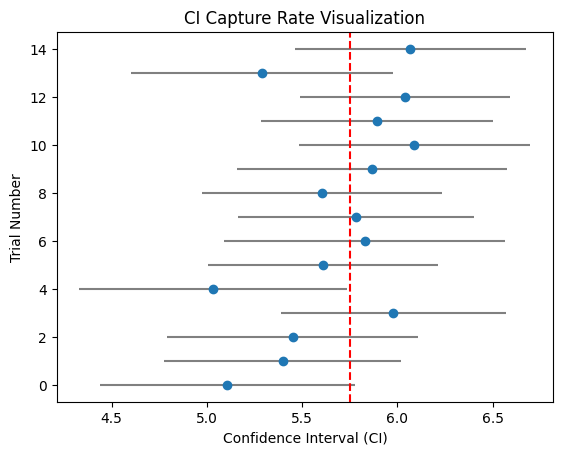

In [102]:
# Random Sampling Simulation (with replacement for independence)
sim_sample = np.random.choice(time_spent_daily, size=(1000, 35), replace=True)  #<- SRS Simulation
sim_mean = sim_sample.mean(axis=1)              #<- Simulation Sample Means
sim_stdev = sim_sample.std(ddof=1, axis=1)      #<- SImulatino Sample Standard Deviations

sim_data = {'mean': sim_mean, 'stdev': sim_stdev, 'MOE':[], 'lower ci': [], 'upper ci': []} #<- Simulation data storage
for s_stat in zip(sim_mean, sim_stdev):                     #<- Manual computing Confidence Interval

    # Calculating Confidence Level
    sim_se = s_stat[1]/np.sqrt(35)                          #<- SE
    sim_tcrit = scistat.t.ppf((1 + .95)/2, df=35-1)         #<- t Crit. Val.
    sim_moe = sim_se * sim_tcrit                            #<- Margin of Error

    sim_conf_inter = scistat.t.interval(conf_lvl, df=35 - 1, loc=s_stat[0], scale=sim_se)   #<- Confidence Interval
    
    # Appending Information to the Empty Dict
    sim_data['MOE'].append(sim_moe)
    sim_data['lower ci'].append(sim_conf_inter[0].round(3))
    sim_data['upper ci'].append(sim_conf_inter[1].round(3))

# Df for Better Information Visualization
sim_df = pd.DataFrame(sim_data)

# Counting Capture Percentage
capture_count = 0
for i, sample in sim_df.iterrows():
    if sample['lower ci'] < mean < sample['upper ci']:  #<- If mean > lower CI, and mean < upper CI
        capture_count += 1                              #<- Incrementation

# Plotting the Simulation Result
plt.errorbar(x=sim_df['mean'].head(15), y=sim_df.index[:15], xerr=sim_df['MOE'].head(15), fmt='o', ecolor='gray')
plt.axvline(x=mean, color='red', linestyle='--')
plt.title('CI Capture Rate Visualization')
plt.xlabel('Confidence Interval (CI)')
plt.ylabel('Trial Number')

# Terminal Output
print(f"Supposed Population Mean = {mean:.3f} hours (red line)")
print(f"Means of Sample Means = {sim_mean[:5]}")
print(f"Stdev of Samples = {sim_stdev[:5]}\n")
print(f"Capture Percentage = {capture_count/len(sim_df) * 100:.2f}%")
sim_df.head(5)

### **Inferential Interpretation**:
- **Look for **`Capture Percentage`** on the terminal output**, it means:
    - We run a trial repeatedly, pick samples, then get their Confidence Interval.
    - Out of those trials, around $95$% of them caught our average daily duration of studying.

# **Hypothesis Testing**
### I intend to study **more than 4 hours a day** to say that I am productive and consistent in learning about data analysis. I want to find out if I really did in these past daily study session.

**Null** Hypothesis: $\mu = 4$ hours (not been consistent)  
**Alternative** Hypothesis: $\mu > 4$ hours (been consistent)  
Significance level: $\alpha = 0.05$

In [103]:
dfgroup_date_timespent.head(5)

,date,time spent,time spent (float),month,day,month/day,reg. pred.,raw resid
0,2025-03-31,0 days 03:04:00,3.066667,3,31,3/31,5.627616,-2.560949
1,2025-04-01,0 days 03:23:00,3.383333,4,1,4/1,5.630360,-2.247027
2,2025-04-02,0 days 07:43:00,7.716667,4,2,4/2,5.633104,2.083563
3,2025-04-03,0 days 04:28:00,4.466667,4,3,4/3,5.635848,-1.169181
4,2025-04-04,0 days 06:04:00,6.066667,4,4,4/4,5.638592,0.428075


In [104]:
result = scistat.ttest_1samp(time_spent_daily, popmean=4)                               #<- 1-sample t test
p_val = result.pvalue / 2                                                               #<- p-value

# Result and Terminal Ouput
if p_val > 0.05:
    print(f"Fail to Reject Null Hypothesis ({p_val: .8f} > 0.05 is {p_val > 0.05})")    #<- Fail to reject H_0
else:                   
    print(f"Reject Null Hypothesis ({p_val: .8f} > 0.05 is {p_val > 0.05})")            #<- Reject H_0

Reject Null Hypothesis ( 0.00000000 > 0.05 is False)


**Inference:**
- Reject Null Hypothesis
- There's **not enough evidence to conclude that I have been not consistent** for these past daily study sessions I had.
- The data suggests the alternative hypothesis that **I have been consistent, but it needs further analysis and study** to conclude safely this hypothesis.

### **What is the probability that I will study less than 4 hours in a day?**

In [105]:
proba_less_4_hr = scistat.norm.cdf(4, loc=mean, scale=stdev)

print(f"P(x < 4 hrs daily) = {proba_less_4_hr * 100: .2f}%")

P(x < 4 hrs daily) =  16.14%


#### The probability of me studying less than $4$ hours in a day is $20.01$%

### **What is the probability that I will study between 4 to 6 hours daily?**

In [106]:
proba_less_than_6 = scistat.norm.cdf(6, loc=mean, scale=stdev)

print(f"P(between 4 to 6 hours) = {(proba_less_than_6 - proba_less_4_hr) * 100: .2f}%")

P(between 4 to 6 hours) =  39.45%


#### The probability of me studying between $4$ to $6$ hours a day is $35.76$%

In [107]:
df = df.set_index(df.columns[0])
pd.pivot_table(df[df['month str'] == 'May'], values='time spent (float)', index='month/day', sort=False, aggfunc='sum').reset_index()

,month/day,time spent (float)
0,5/1,5.416667
1,5/5,5.766667
2,5/6,5.650000
3,5/7,7.000000
4,5/8,6.933333
5,5/9,7.566667
6,5/10,6.400000
7,5/11,6.650000
8,5/13,6.700000
9,5/14,8.800000


In [108]:
df.loc[(df['month str'] == 'May') & (df['day'] > 25), ['month/day', 'day', 'time spent (float)', 'Unit', 'topic']]

,month/day,day,time spent (float),Unit,topic
entry_num,,,,,
375,5/26,26,0.450000,12,Free response example: Significance test for a...
376,5/26,26,0.300000,12,Free response example: Significance test for a...
377,5/26,26,0.066667,12,Hypothesis testing and p-values
378,5/26,26,0.633333,12,Hypothesis testing and p-values
379,5/26,26,0.216667,12,One-tailed and two-tailed tests
380,5/26,26,0.083333,12,z-statistics vs. t-statistics
381,5/26,26,0.233333,12,Small sample hypothesis test
382,5/26,26,0.300000,12,Large sample hypothesis testing
383,5/26,26,1.316667,12,Unit test


In [109]:
df

,date,time_start,time_end,topic,Lesson,Category,Unit,time spent,time spent (float),unit desc.,time_start_flt,time_end_flt,month,month str,day,day of week,month/day
entry_num,,,,,,,,,,,,,,,,,
1,2025-03-31,1900-01-01 21:40:00,1900-01-01 00:45:00,lesson from unit 7,NaN,khan academy,7,0 days 03:04:00,3.066667,Probability,21.666667,0.750000,3,March,31,Monday,3/31
2,2025-04-01,1900-01-01 12:23:00,1900-01-01 12:45:00,lesson from unit 7,NaN,khan academy,7,0 days 00:22:00,0.366667,Probability,12.383333,12.750000,4,April,1,Tuesday,4/1
3,2025-04-01,1900-01-01 13:50:00,1900-01-01 14:49:00,lesson from unit 7,NaN,khan academy,7,0 days 00:59:00,0.983333,Probability,13.833333,14.816667,4,April,1,Tuesday,4/1
4,2025-04-01,1900-01-01 18:12:00,1900-01-01 19:00:00,lesson from unit 7,NaN,khan academy,7,0 days 00:48:00,0.800000,Probability,18.200000,19.000000,4,April,1,Tuesday,4/1
5,2025-04-01,1900-01-01 23:30:00,1900-01-01 00:45:00,lesson from unit 7,NaN,khan academy,7,0 days 01:14:00,1.233333,Probability,23.500000,0.750000,4,April,1,Tuesday,4/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,2025-07-03,1900-01-01 15:23:00,1900-01-01 17:01:00,Personal Project (time spent - refinement),NaN,personal project,<NA>,0 days 01:38:00,1.633333,NaN,15.383333,17.016667,7,July,3,Thursday,7/3
561,2025-07-03,1900-01-01 21:04:00,1900-01-01 21:12:00,Personal Project (time spent - refinement),NaN,personal project,<NA>,0 days 00:08:00,0.133333,NaN,21.066667,21.200000,7,July,3,Thursday,7/3
562,2025-07-04,1900-01-01 12:45:00,1900-01-01 14:40:00,Portfolio Making (time spent),NaN,portfolio making,<NA>,0 days 01:55:00,1.916667,NaN,12.750000,14.666667,7,July,4,Friday,7/4


In [110]:
# import pandas as pd
# from sqlalchemy import create_engine
# import pymysql

In [111]:
# file_name = 'Time spend studying 2.csv'
# file_loc = 'C:\\Users\\Acer\\Documents\\SoftDev\\Projects'
# df = pd.read_csv(f'{file_loc}\\{file_name}')

# df.columns = ['entry_num', 'date', 'time_start', 'time_end', 'topic', 'Unit', 'Lesson', 'Category']
# df

In [112]:
# username = 'Tvan'
# password = 'Tvan217desu~'
# host = 'localhost'
# port = '3306'
# db = 'time_spent_studying'

# engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{db}')

# df.to_sql('time_spent_data2', engine, if_exists='replace', index=False)